In [1]:
# !pip3 install opencv-python
# !apt-get update && apt-get install libgl1

import os

import numpy as np
from netCDF4 import Dataset

import seaborn as sns
from tqdm import tqdm
from glob import glob
import pandas as pd
import time
import geopandas as gpd # GeoPandas(지오판다스)
import matplotlib.pyplot as plt
from rasterio.plot import show
import rasterio

In [2]:
# path = os.getcwd()
# data_path = os.getcwd()
# proj_path = os.getcwd()
path = os.path.join("/workspace")
data_path = os.path.join(path,'cmaqProjectdata')

* 데이터셋

In [3]:
avg_conc_path_list = glob(os.path.join(data_path,"yearly_data","concentration","*"))
avg_conc_path_info_df = pd.DataFrame()
avg_conc_path_info_df.loc[:,'path'] = avg_conc_path_list
avg_conc_path_info_df.loc[:,'Run'] = [int(path.split("/")[-1].split(".")[1]) for path in avg_conc_path_list]

avg_ems_path_list = glob(os.path.join(data_path,"yearly_data","emission","*"))
avg_ems_path_info_df = pd.DataFrame()
avg_ems_path_info_df.loc[:,'path_ems'] = avg_ems_path_list
avg_ems_path_info_df.loc[:,'Run'] = [int(path.split("/")[-1].split(".")[1]) for path in avg_ems_path_list]

cont_matrix = pd.read_csv(os.path.join(data_path,"02_Emission_0518.csv"))

merged_info_df = pd.merge(avg_conc_path_info_df, avg_ems_path_info_df, how='left', on='Run')
merged_info_df = pd.merge(merged_info_df, cont_matrix, how='left', on='Run')

target_arr = np.concatenate([np.array(Dataset(path, 'r').variables['PM2_5'][0,0,:,:])[np.newaxis,:,:] for path in merged_info_df.path.tolist()])[:,:,:,None]


smoke_list = [Dataset(path, 'r') for path in merged_info_df.path_ems.tolist()]
smoke_chem_list = ['SO2', 'PM2_5', 'NOx', 'VOCs', 'NH3', 'CO']
smoke_val_list = []
for i in smoke_chem_list:
    smoke_arr_i = np.concatenate([np.array(Dataset(path, 'r').variables[i][0,0,:,:])[np.newaxis,:,:] for path in merged_info_df.path_ems.tolist()])[:,:,:,None]
    smoke_val_list.append(smoke_arr_i)

smoke_arr = np.concatenate(smoke_val_list, axis = 3)
smoke_arr.shape, target_arr.shape
# input_cols = list(set(merged_info_df.columns) - set(['path','Run','path_ems']))
input_cols = merged_info_df.columns.tolist()
input_cols.remove('path')
input_cols.remove('Run')
input_cols.remove('path_ems')


control_matrix = merged_info_df.loc[:,input_cols].values

In [4]:
control_matrix.shape, target_arr.shape, smoke_arr.shape

((120, 119), (120, 82, 67, 1), (120, 82, 67, 6))

In [5]:
control_matrix_df = merged_info_df.loc[:,input_cols]

In [6]:
control_matrix_df.head()

1)A_ALL_POW  2)A_ALL_IND  3)A_ALL_MOB  4)A_ALL_RES  5)A_NH3_AGR   
0     0.987841     1.180471     0.798736     1.141712     1.020628  \
1     1.133672     0.929272     1.138921     1.334243     1.006343   
2     0.525706     0.677189     0.822045     1.338972     1.364861   
3     1.034355     1.400949     0.961979     1.195736     1.430444   
4     1.387527     0.770746     1.021555     1.073785     1.252608   

   6)A_ALL_SLV  7)A_ALL_OTH  8)B_ALL_POW  9)B_ALL_IND  10)B_ALL_MOB  ...   
0     1.331100     1.305813     1.270536     1.046187      1.318609  ...  \
1     0.958524     1.054640     0.806065     0.648616      1.168343  ...   
2     1.013928     0.822741     0.511373     1.307777      1.021716  ...   
3     1.420656     1.143664     1.093757     1.045100      1.260465  ...   
4     0.775638     0.559126     0.743691     1.172614      1.224526  ...   

   110)P_NH3_AGR  111)P_ALL_SLV  112)P_ALL_OTH  113)Q_ALL_POW  114)Q_ALL_IND   
0       1.479545       0.846181       0.925406       1.038219       0.780984  \
1       1.014030       0.520941       1.320424       0.558765       0.543870   
2       0.707523       1.278578       1.156775       1.352182       1.474289   
3       1.330796       0.640709       1.267226       1.412690       0.871079   
4       1.353049       1.484595       1.082766       1.376077       0.632523   

   115)Q_ALL_MOB  116)Q_ALL_RES  117)Q_NH3_AGR  118)Q_ALL_SLV  119)Q_ALL_OTH  
0       1.177681       0.580686       1.413780       0.657763       1.257242  
1       1.096737       1.156281       0.686289       1.415363       1.135552  
2       1.481860       1.122850       0.671594       0.685490       0.637784  
3       0.987460       1.007799       0.714824       0.548089       0.785760  
4       1.404446       1.344944       0.825372       0.725225       0.943335  

[5 rows x 119 columns]

* 픽셀별 시도 인덱싱

In [7]:
ctp_rvn_gpd = gpd.GeoDataFrame.from_file(os.path.join(data_path,"geoinfodata","시도","ctp_rvn.shp",),encoding = 'cp949')
ctp_rvn_gpd.crs = {'init':'epsg:5179'}

/usr/local/lib/python3.8/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [8]:
ctp_rvn_gpd.head()

CTPRVN_CD CTP_ENG_NM CTP_KOR_NM   
0        11      Seoul      서울특별시  \
1        26      Busan      부산광역시   
2        27      Daegu      대구광역시   
3        28    Incheon      인천광역시   
4        29    Gwangju      광주광역시   

                                            geometry  
0  POLYGON ((966987.226 1941110.946, 966987.119 1...  
1  MULTIPOLYGON (((1148194.981 1685460.055, 11481...  
2  POLYGON ((1087859.999 1760097.461, 1087859.951...  
3  MULTIPOLYGON (((847834.755 1881816.658, 847840...  
4  POLYGON ((932712.687 1696168.692, 932781.680 1...

In [9]:
from shapely.geometry import Point

In [10]:
# lcc프로젝션 기본 레스터 제작
projout = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'

# out_grid = make_geocube(vector_data=test_data, measurements=["습도(%)"], geom=geom,resolution=(9000, 9000), fill=0, output_crs=projout) #for most crs negative comes first in resolution
x_m = list(range(-180000,-180000 + 9000 * 67, 9000))
y_m = list(range(-585000,-585000 + 9000 * 82, 9000))

print(len(x_m), len(y_m))

grid_points = []
for x_i in x_m:
    for y_i in y_m:
        grid_points.append(Point(x_i,y_i))

grid_data = pd.DataFrame(grid_points, columns=['geometry'])

grid_data = gpd.GeoDataFrame(grid_data, geometry='geometry')
grid_data.crs = ctp_rvn_gpd.to_crs(projout).crs
grid_data.loc[:,'x_m'] = grid_data.geometry.x
grid_data.loc[:,'y_m'] = grid_data.geometry.y
grid_data.loc[:,'value'] = 0
grid_data.loc[:,'index'] = grid_data.index

# out_grid = make_geocube(vector_data=grid_data, measurements=["value"],resolution=(9000, 9000), fill=0, output_crs=projout) #for most crs negative comes first in resolution
# out_grid["value"].rio.to_raster("base_lcc.tif")


67 82


In [11]:
grid_data.head()

geometry       x_m       y_m  value  index
0  POINT (-180000.000 -585000.000) -180000.0 -585000.0      0      0
1  POINT (-180000.000 -576000.000) -180000.0 -576000.0      0      1
2  POINT (-180000.000 -567000.000) -180000.0 -567000.0      0      2
3  POINT (-180000.000 -558000.000) -180000.0 -558000.0      0      3
4  POINT (-180000.000 -549000.000) -180000.0 -549000.0      0      4

In [12]:
joined = gpd.sjoin(ctp_rvn_gpd, grid_data.to_crs(5179), op='contains')
indexed_grid_point = pd.merge(grid_data, joined.loc[:,['CTPRVN_CD', 'CTP_ENG_NM', 'CTP_KOR_NM', 'index_right']], how='left', left_on='index', right_on='index_right')
indexed_grid_point = gpd.GeoDataFrame(indexed_grid_point, geometry='geometry')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/tmp/ipykernel_3485743/1405158965.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:5179 +type=crs
Right CRS: EPSG:5179

  joined = gpd.sjoin(ctp_rvn_gpd, grid_data.to_crs(5179), op='contains')


<Axes: >

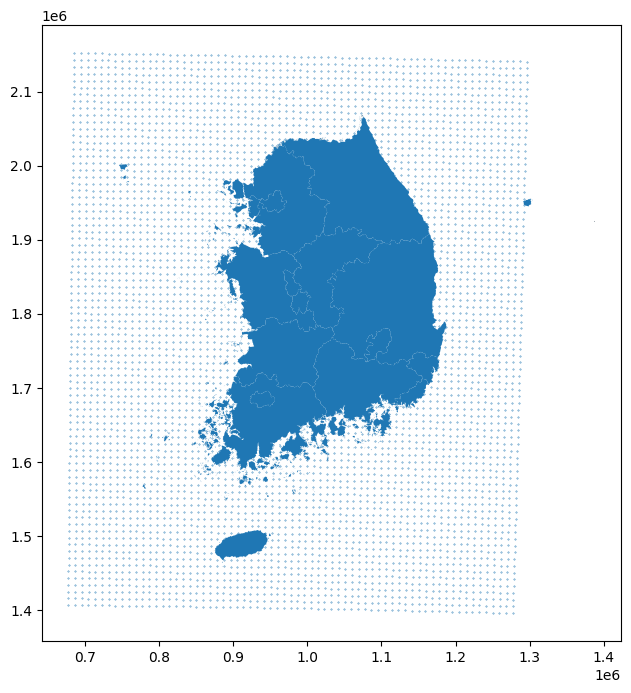

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))
indexed_grid_point.to_crs(5179).plot(ax = ax, markersize = 0.1)
ctp_rvn_gpd.plot(ax = ax)

* 1*1 으로 82*67 중 도시부분만 피팅

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [15]:
# 서울시만 피팅하는 버전 또는 바다 제거
results_pd = pd.DataFrame(columns=['id','ctp_kor_nm','train_mse','test_mse','train_rmse','test_rmse','train_r2','test_r2','x','y'])
# X_train, X_test, y_train, y_test = train_test_split(control_matrix_df, np.mean(target_arr[:,x_start:x_end,y_start:y_end,:], axis = (1,2)), test_size=0.2, random_state=42 )
X_train, X_test, y_train, y_test = train_test_split(control_matrix_df, target_arr, test_size=0.2, random_state=42 )
models = []


# for pix_index in indexed_grid_point.loc[indexed_grid_point.CTP_KOR_NM == '경상북도'].index.tolist():
# for pix_index in indexed_grid_point.dropna().index.tolist():
for pix_index in indexed_grid_point.loc[~indexed_grid_point.CTP_KOR_NM.isna()].index.tolist():
    print(pix_index)
    x, y = pix_index%82,pix_index//82
    y_train_sub = y_train[:,x,y,:]
    y_test_sub = y_test[:,x,y,:]

    rand_reg = RandomForestRegressor(random_state=42, max_depth=3, n_estimators=50)
    rand_reg.fit(X_train, y_train_sub.ravel())
    models.append(rand_reg)
   
    y_pred_train = rand_reg.predict(X_train)
    y_pred = rand_reg.predict(X_test)

    train_mse = mean_squared_error(y_train_sub, y_pred_train, squared= True)
    test_mse = mean_squared_error(y_test_sub, y_pred, squared= True)

    train_rmse = mean_squared_error(y_train_sub, y_pred_train, squared= False)
    test_rmse = mean_squared_error(y_test_sub, y_pred, squared= False)

    train_r2 = r2_score(y_train_sub, y_pred_train,)
    test_r2 = r2_score(y_test_sub, y_pred,)
    

    i_ctp_nm = indexed_grid_point.CTP_KOR_NM.values[pix_index]

    results_pd.loc[pix_index,:] = [pix_index,i_ctp_nm,train_mse,test_mse,train_rmse,test_rmse,train_r2,test_r2,x,y]
 

results_pd.loc[:,'model'] = models


1455
1584
1664
1744
1748
1749
1752
1777
1778
1812
1826
1832
1834
1854
1855
1893
1894
1895
1908
1909
1910
1911
1916
1935
1936
1937
1941
1942
1948
1976
1977
1978
1992
1993
1994
1996
1997
1999
2000
2001
2014
2017
2018
2019
2020
2021
2029
2030
2058
2059
2060
2069
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2096
2097
2098
2099
2100
2101
2102
2103
2109
2111
2140
2141
2142
2143
2150
2151
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2187
2190
2191
2193
2194
2222
2223
2224
2225
2235
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2305
2306
2307
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2349
2350
2351
2352
2353
2354
2355


In [16]:
results_pd.head()

id ctp_kor_nm train_mse  test_mse train_rmse test_rmse  train_r2   
1455  1455      인천광역시  0.002465  0.015303   0.049647  0.123704  0.808644  \
1584  1584       전라남도  0.003944   0.01549   0.062799   0.12446  0.884442   
1664  1664       전라남도    0.0045  0.016588    0.06708  0.128792   0.89871   
1744  1744       전라남도   0.00498  0.017181   0.070566  0.131075  0.900601   
1748  1748       전라남도  0.007364  0.028789   0.085814  0.169673  0.903066   

       test_r2   x   y                                              model  
1455  0.271099  61  17  (DecisionTreeRegressor(max_depth=3, max_featur...  
1584  0.653533  26  19  (DecisionTreeRegressor(max_depth=3, max_featur...  
1664   0.70971  24  20  (DecisionTreeRegressor(max_depth=3, max_featur...  
1744   0.73345  22  21  (DecisionTreeRegressor(max_depth=3, max_featur...  
1748  0.730211  26  21  (DecisionTreeRegressor(max_depth=3, max_featur...

<Axes: ylabel='Count'>

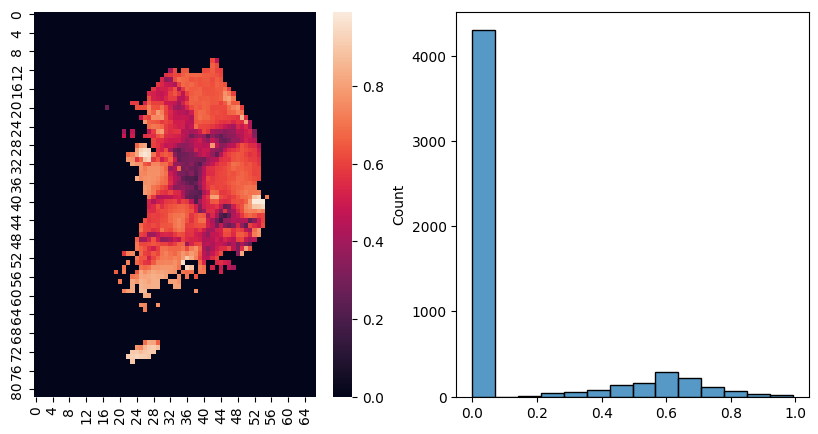

In [17]:
r2_map = np.zeros_like(target_arr[0])
for ind in results_pd.index.tolist():
    ind_val = results_pd.loc[ind,['x', 'y', 'test_r2']].values
    r2_map[ind_val[0],ind_val[1],0] = ind_val[2]

plt.figure(figsize = [10,5])
plt.subplot(1,2,1)
sns.heatmap(r2_map[:,:,0][::-1])

plt.subplot(1,2,2)
sns.histplot(r2_map[:,:,0][::-1].reshape(-1))

<Axes: ylabel='Count'>

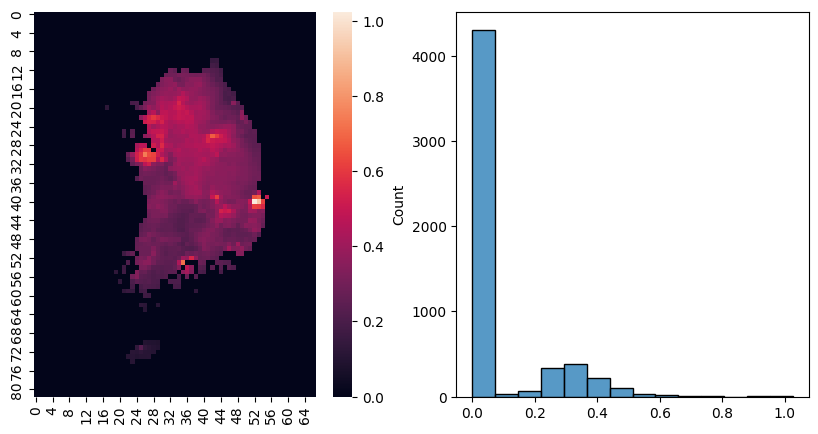

In [18]:
r2_map = np.zeros_like(target_arr[0])
for ind in results_pd.index.tolist():
    ind_val = results_pd.loc[ind,['x', 'y', 'test_rmse']].values
    r2_map[ind_val[0],ind_val[1],0] = ind_val[2]

plt.figure(figsize = [10,5])
plt.subplot(1,2,1)
sns.heatmap(r2_map[:,:,0][::-1])

plt.subplot(1,2,2)
sns.histplot(r2_map[:,:,0][::-1].reshape(-1))

<Axes: ylabel='Count'>

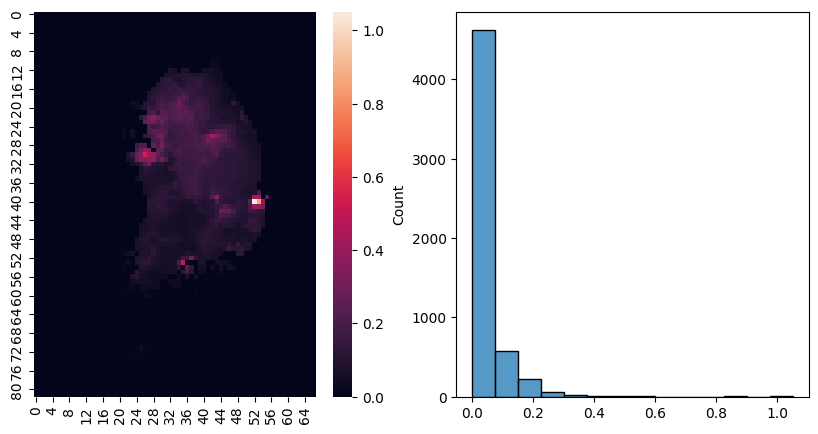

In [19]:
r2_map = np.zeros_like(target_arr[0])
for ind in results_pd.index.tolist():
    ind_val = results_pd.loc[ind,['x', 'y', 'test_mse']].values
    r2_map[ind_val[0],ind_val[1],0] = ind_val[2]

plt.figure(figsize = [10,5])
plt.subplot(1,2,1)
sns.heatmap(r2_map[:,:,0][::-1])

plt.subplot(1,2,2)
sns.histplot(r2_map[:,:,0][::-1].reshape(-1))

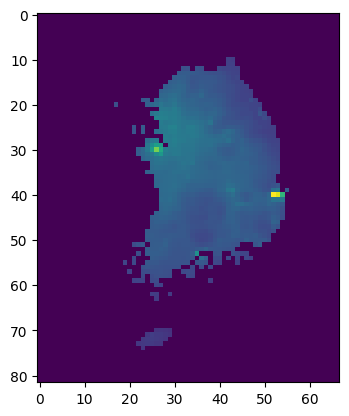

In [20]:
pred_base = np.zeros_like(y_test)
for ind in results_pd.index.tolist():
    ind_val = results_pd.loc[ind,:].values
    pred = ind_val[10].predict(X_test)

    pred_base[:,ind_val[8],ind_val[9],0] = pred
plt.imshow(pred_base[0][::-1])

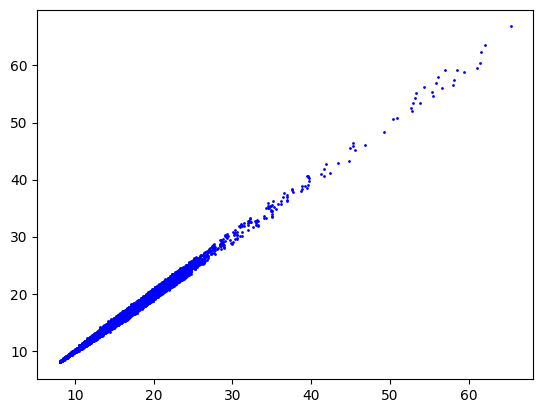

In [21]:
plt.plot(pred_base[pred_base != 0], y_test[pred_base != 0], 'bo', markersize = 1)

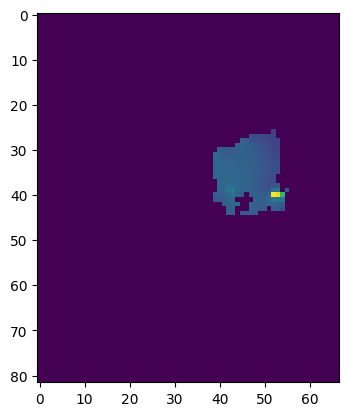

In [22]:
pred_base = np.zeros_like(y_test)
for ind in results_pd.loc[results_pd.ctp_kor_nm == '경상북도'].index.tolist():
    ind_val = results_pd.loc[ind,:].values
    pred = ind_val[10].predict(X_test)

    pred_base[:,ind_val[8],ind_val[9],0] = pred
plt.imshow(pred_base[0][::-1])

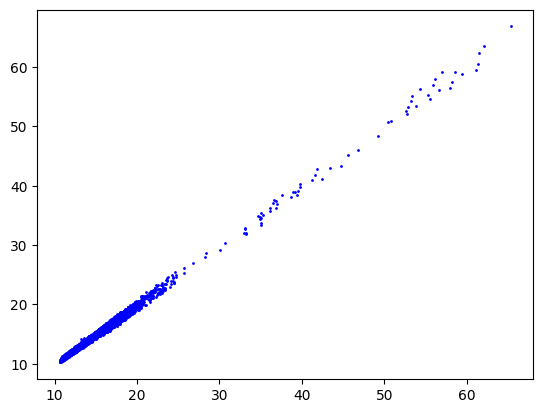

In [23]:
plt.plot(pred_base[pred_base != 0], y_test[pred_base != 0], 'bo', markersize = 1)

/tmp/ipykernel_3485743/818873415.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = [15,5])


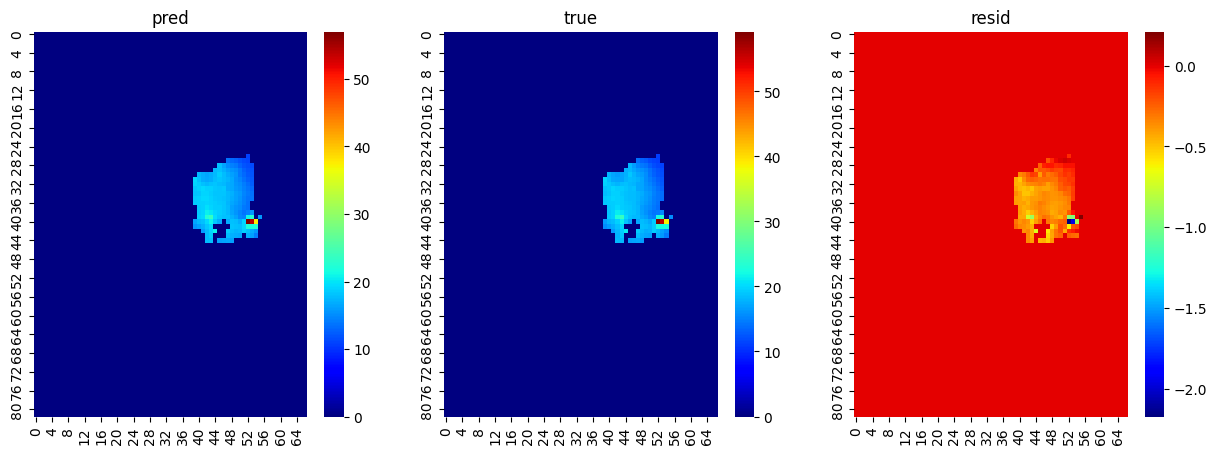

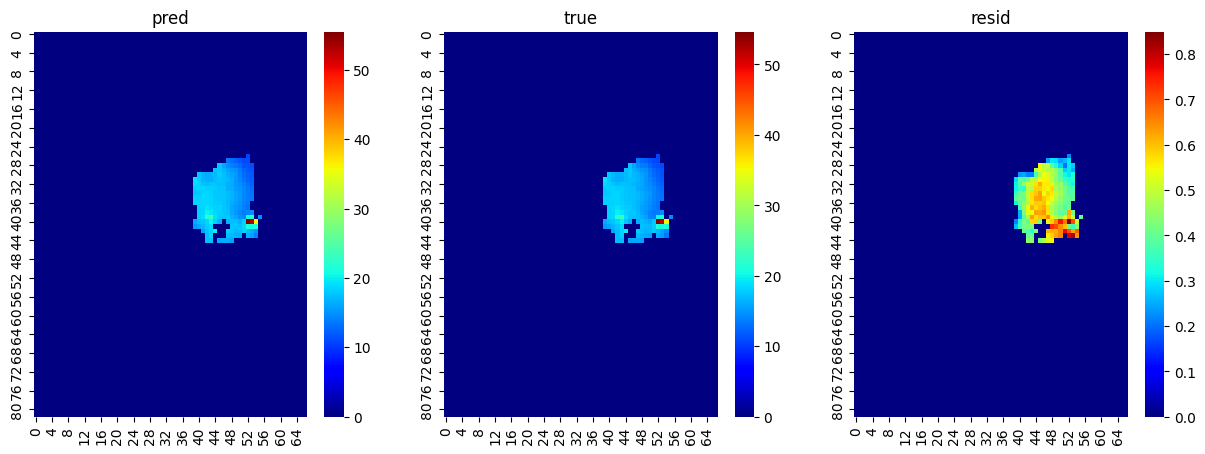

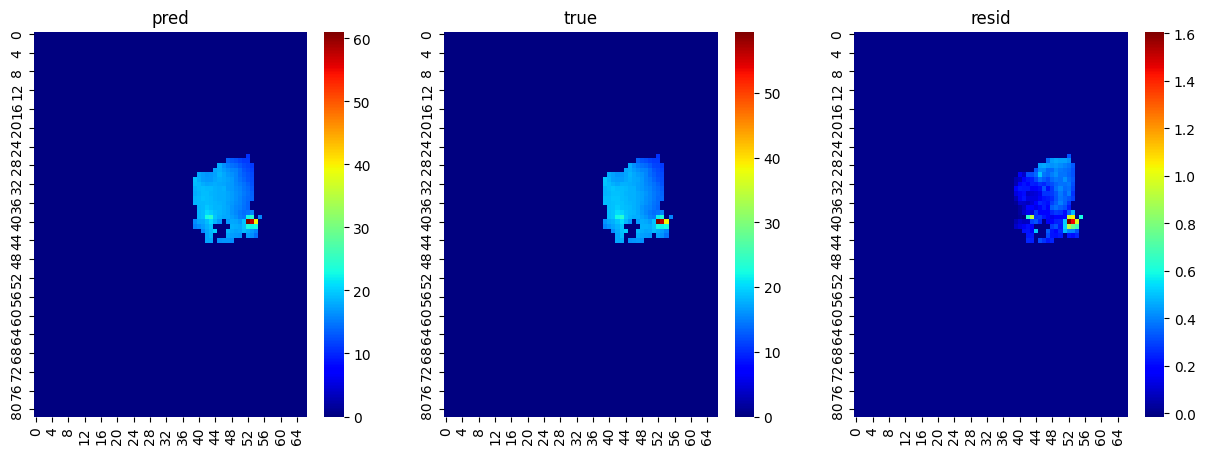

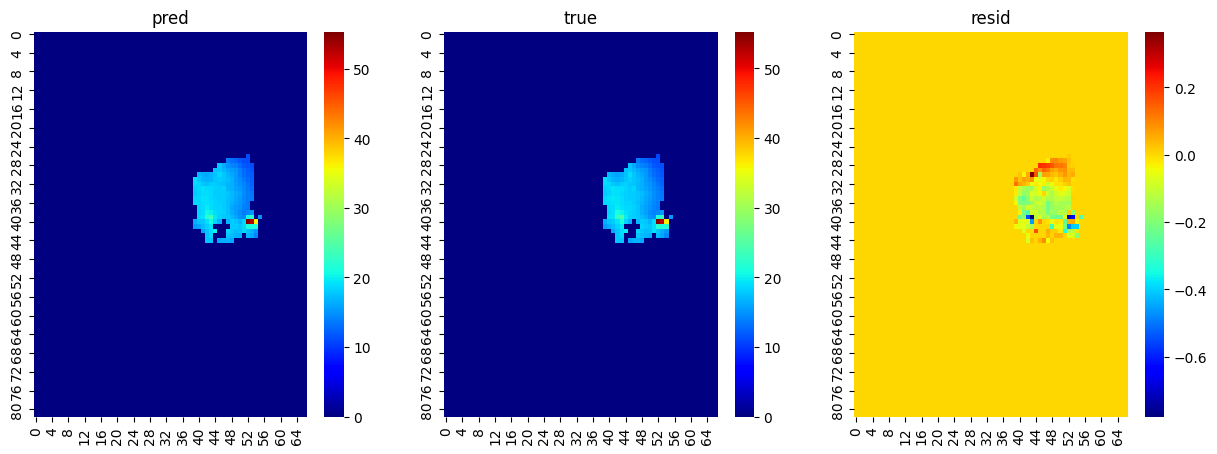

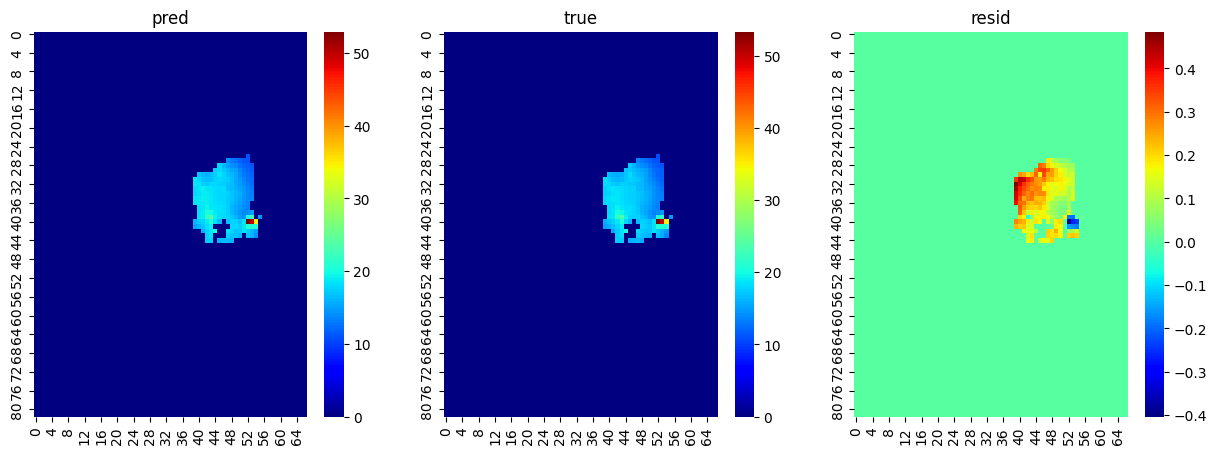

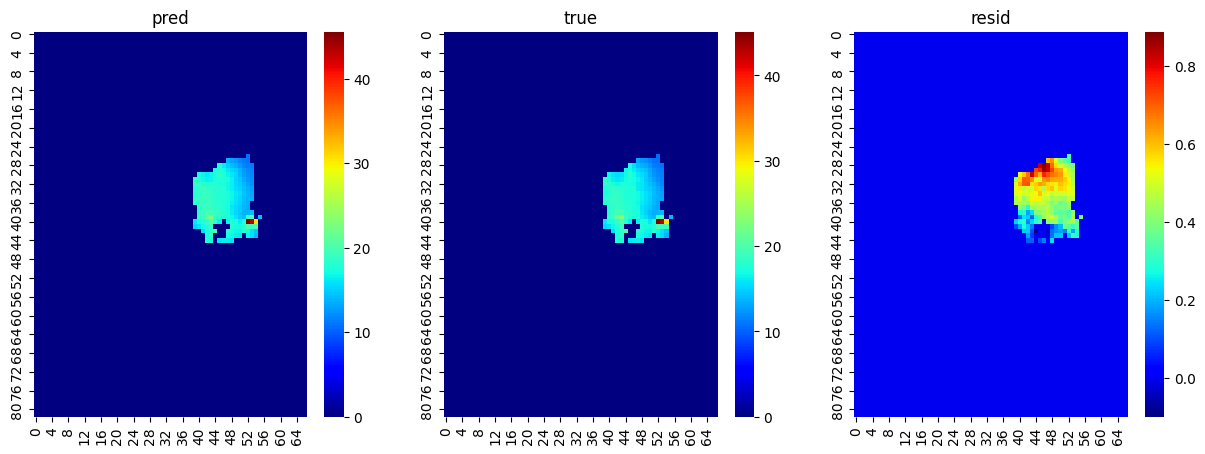

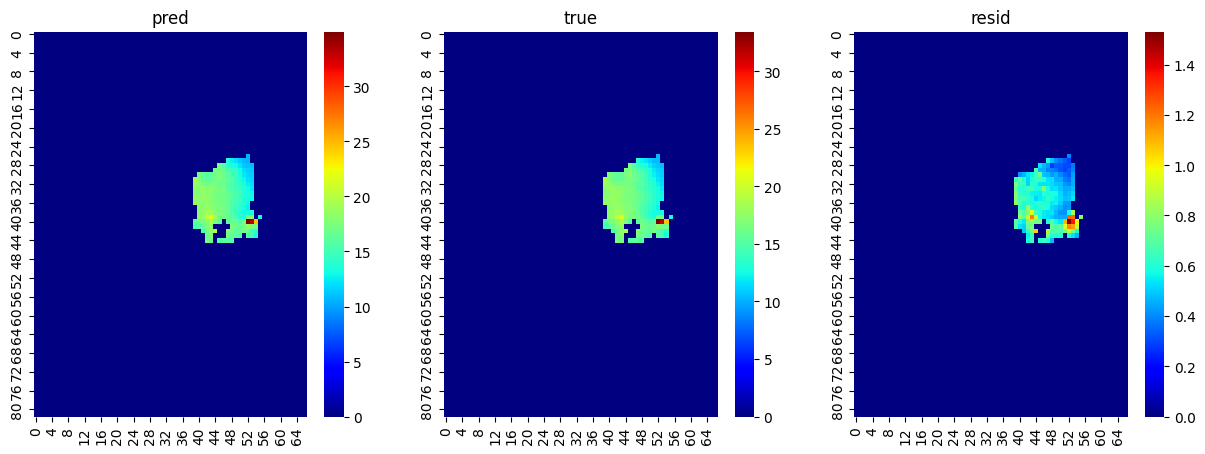

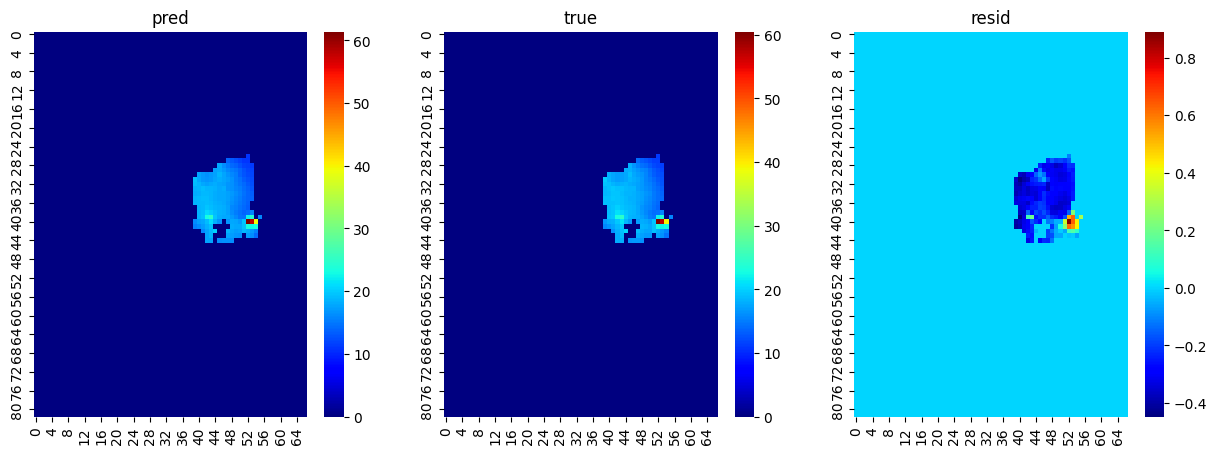

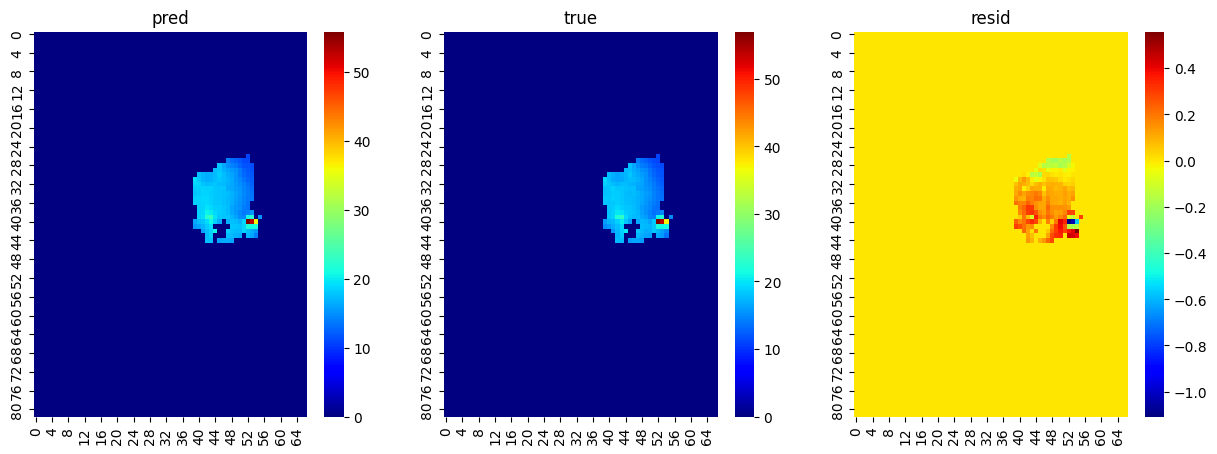

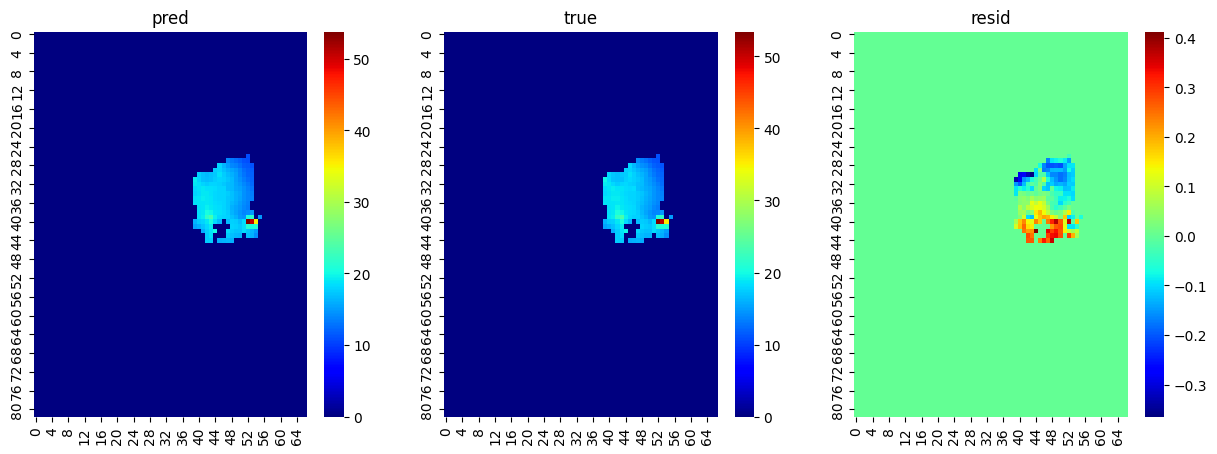

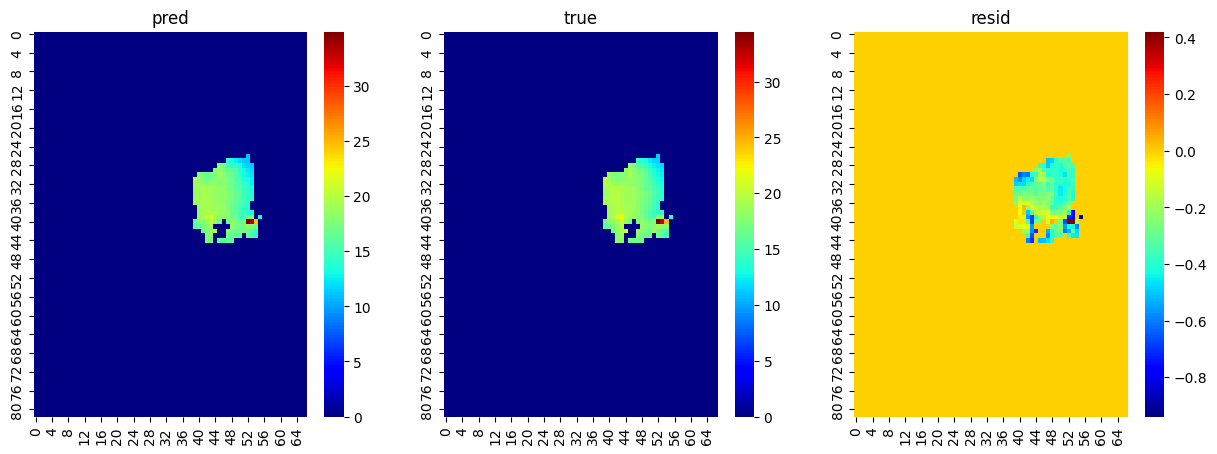

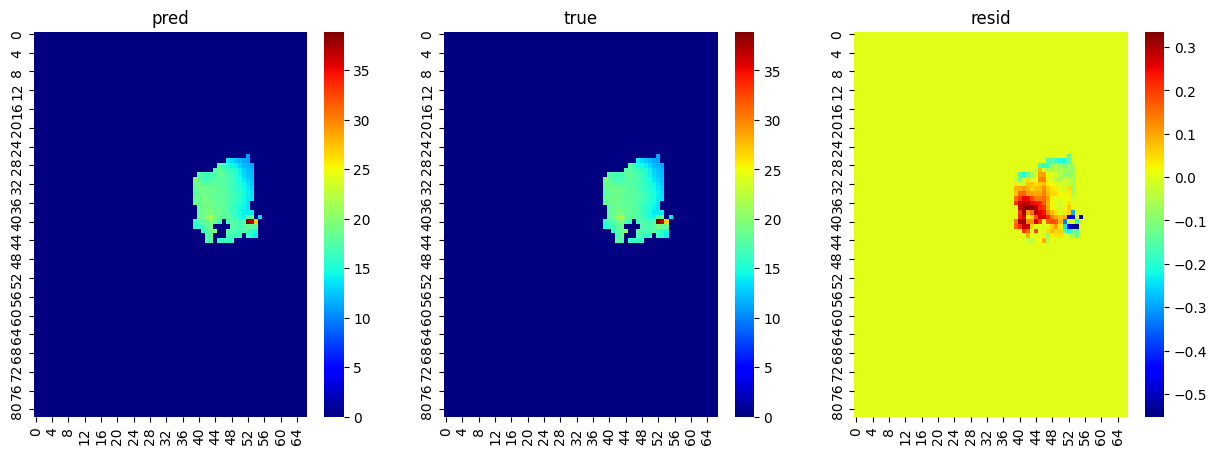

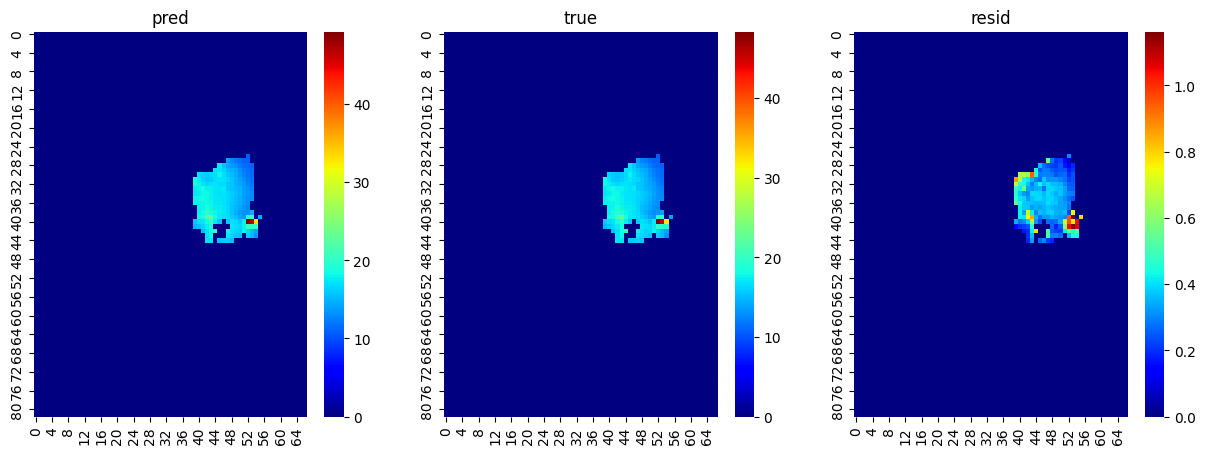

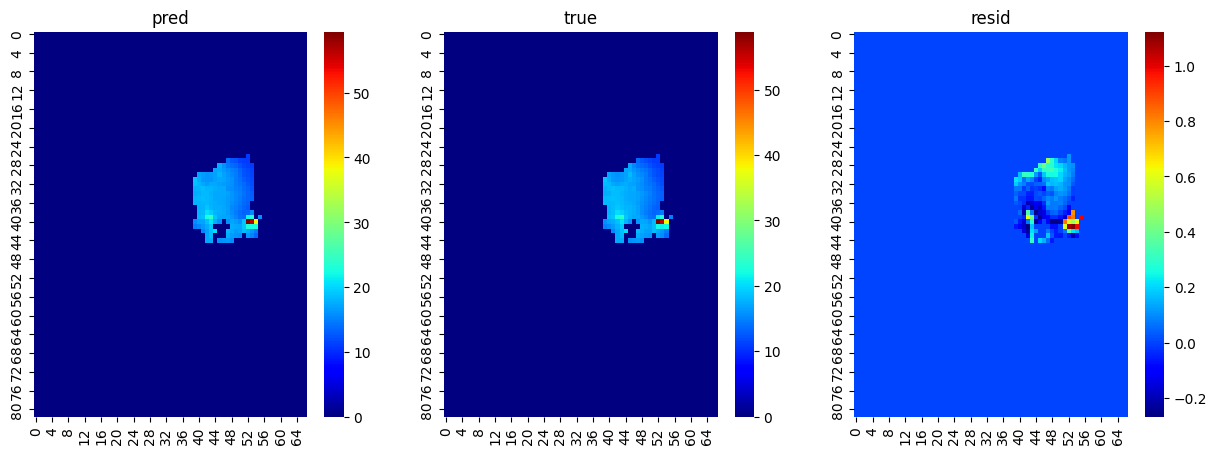

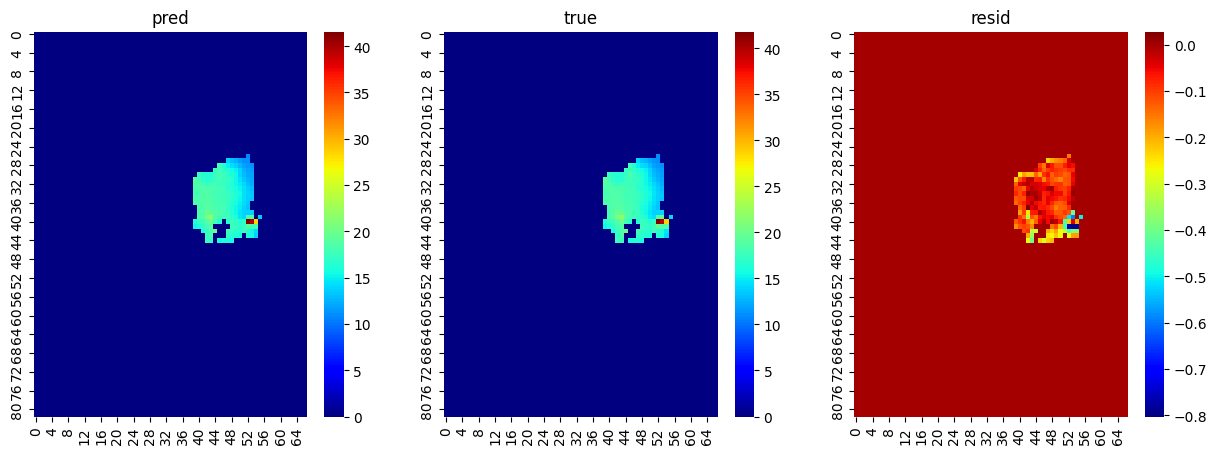

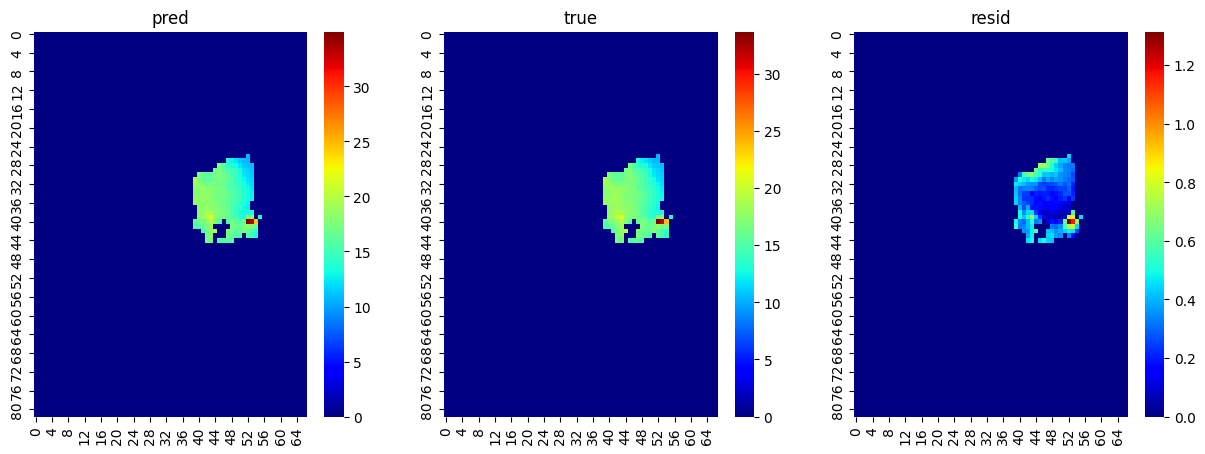

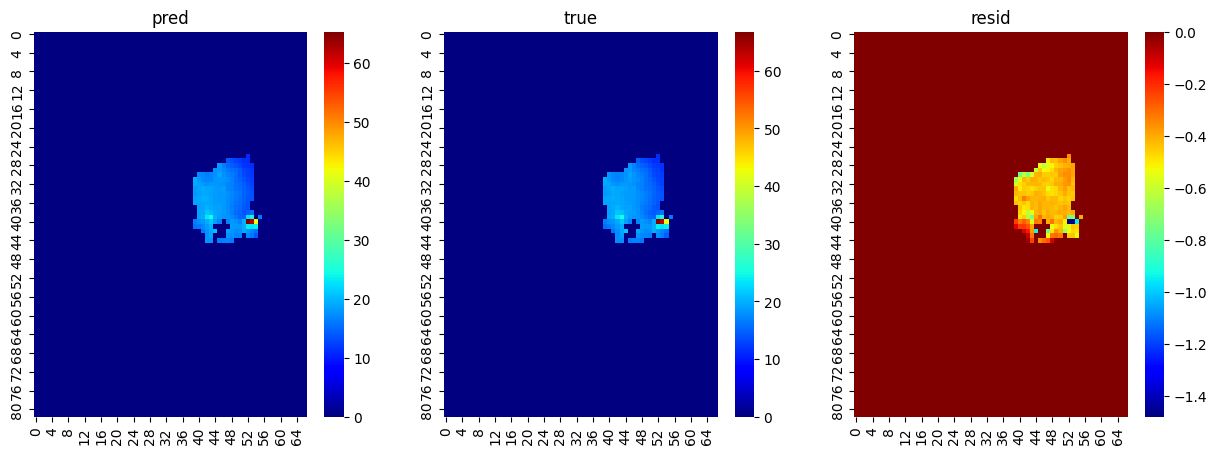

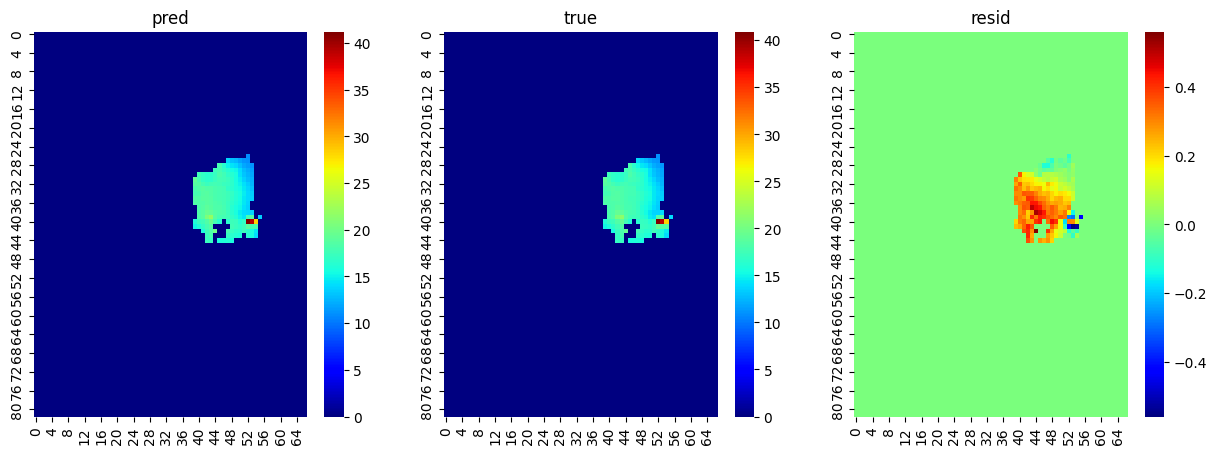

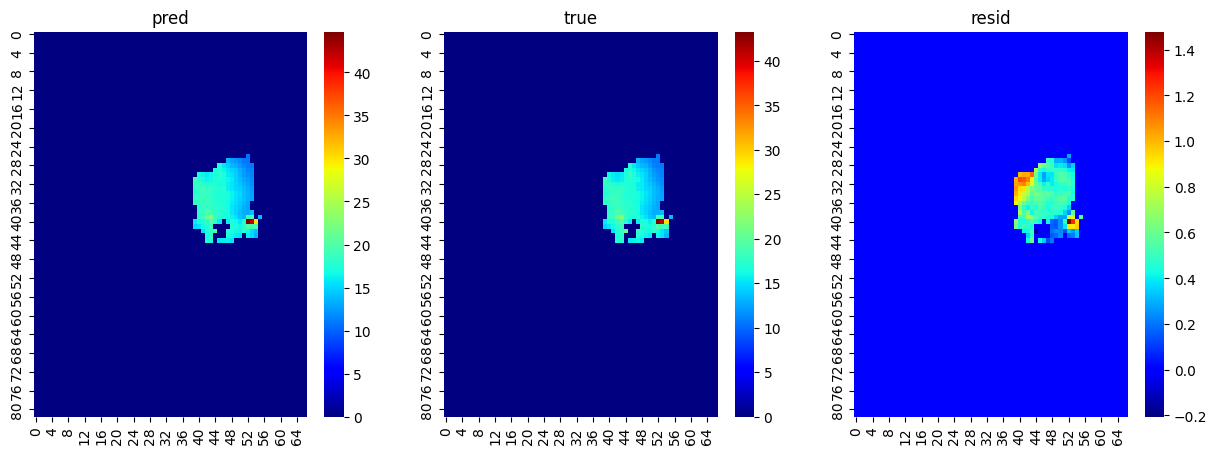

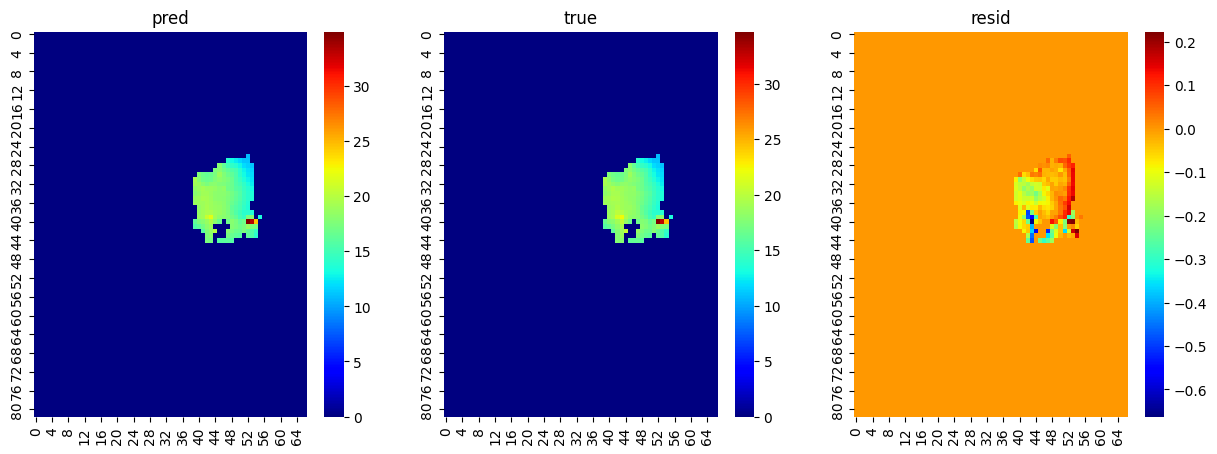

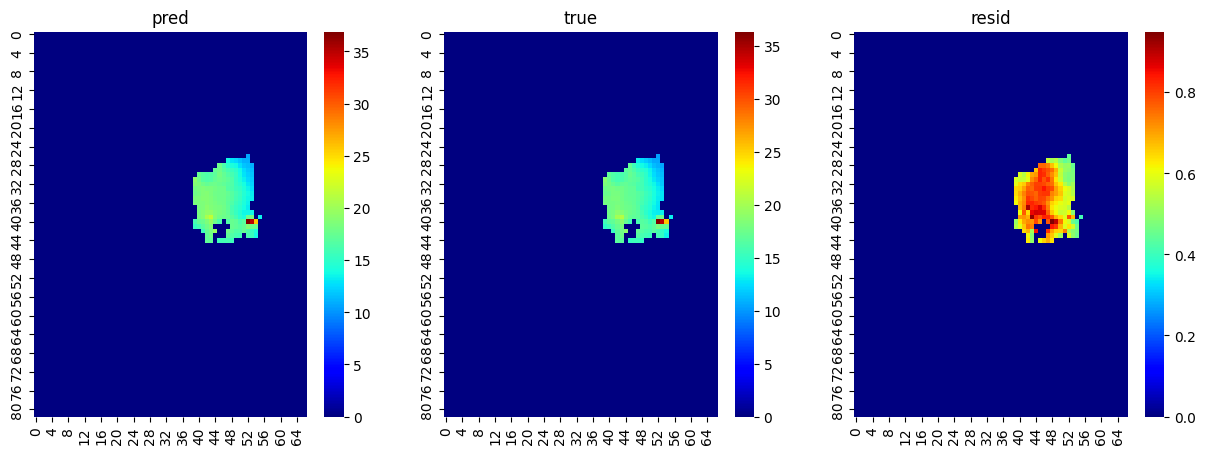

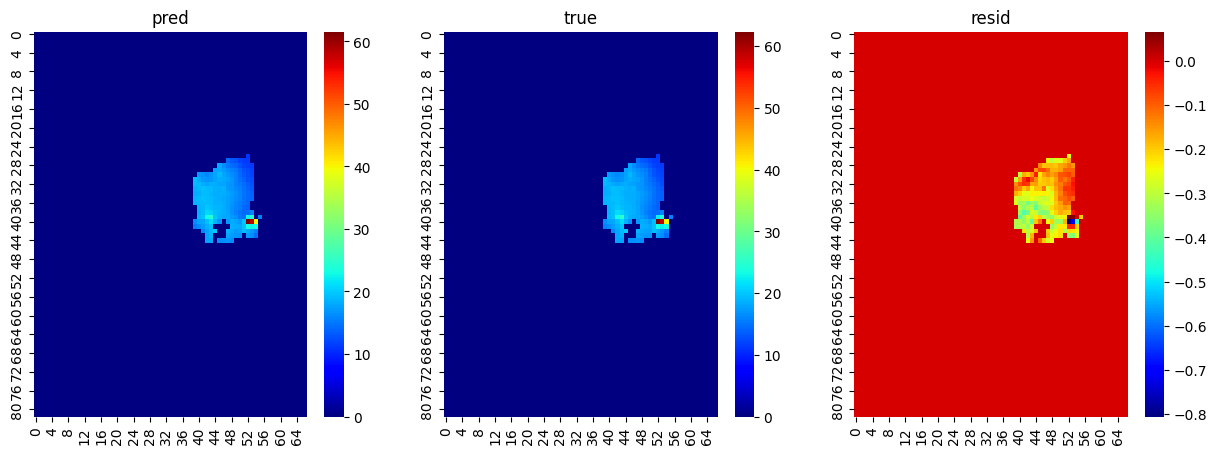

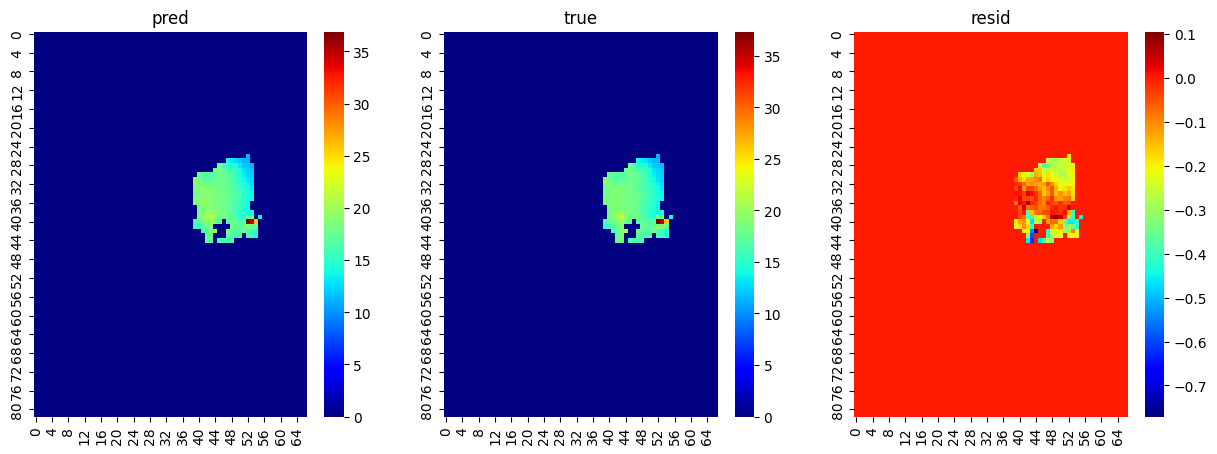

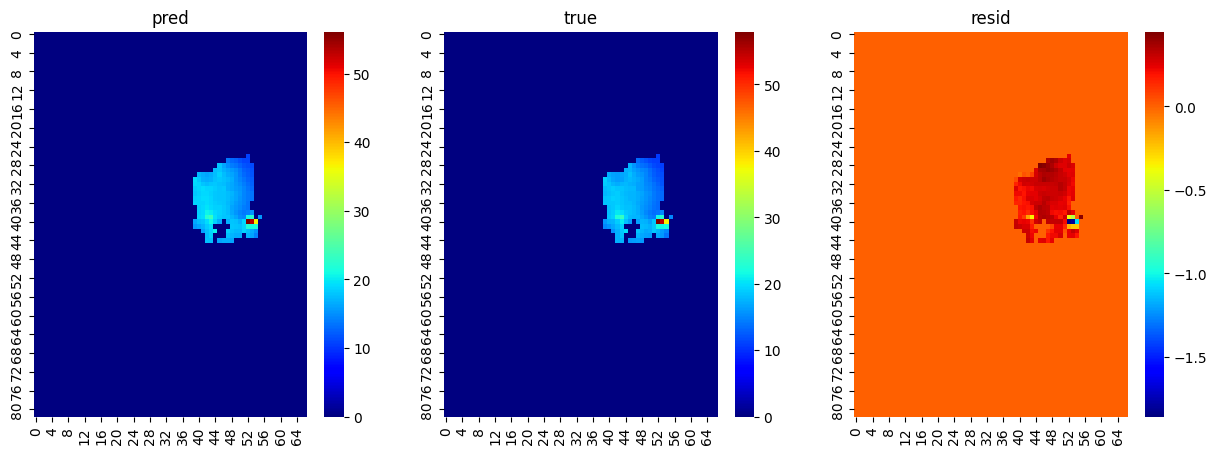

In [24]:
from copy import deepcopy
# asdasd
y_test_copy = deepcopy(y_test)
y_test_copy[np.where(pred_base == 0)] = 0 
for i in range(len(y_test_copy)):
    plt.figure(figsize = [15,5])
    plt.subplot(1,3,1)
    plt.title('pred')
    sns.heatmap(pred_base[i,:,:,0][::-1], cmap = 'jet')
    plt.subplot(1,3,2)
    plt.title('true')
    sns.heatmap(y_test_copy[i,:,:,0][::-1], cmap = 'jet')
    plt.subplot(1,3,3)
    plt.title('resid')
    sns.heatmap(pred_base[i,:,:,0][::-1] - y_test_copy[i,:,:,0][::-1], cmap = 'jet')

# analysis

In [25]:
# 전체 예측 및 shap value, train, test따로
# 딕셔너리 또는 리스트로 각 shap value별 시도 인덱싱 달아주기(인덱스 번호까지)
# 원하는 시도 슬라이싱 해서 서머리 플롯이든 뭐든 도출
import shap

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
# 변수별로 맵이 그려짐(s-val1   맵), (s-val1   맵), (s-val1   맵), (s-val1   맵),
# 그리드별 모델의 루프를 돌릴지, 피처별로 루프를 돌릴지
#


### 어렵지는 않을듯,
# 샘플 n개 예측에 대해 계산
# 그리드 index 에 대해  shap.TreeExplainer를 통해 샘플개수 - 변수갯수로 연결되는 값 뽑아냄
# 루프를 통해 전체 그리드에대해 위 과정
# 피처별로 전체 그리드에 대해 arr을 형성 
# 지도그림

* 전국단위

In [27]:
shap_base = np.zeros([y_test.shape[0],y_test.shape[1],y_test.shape[2],119])
print(shap_base.shape)
for ind in results_pd.index.tolist():
    ind_val = results_pd.loc[ind,:].values
    # pred = ind_val[10].predict(X_test)
    shap_values = shap.TreeExplainer(ind_val[10]).shap_values(X_test)
    shap_base[:,ind_val[8],ind_val[9],:] = shap_values

(24, 82, 67, 119)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


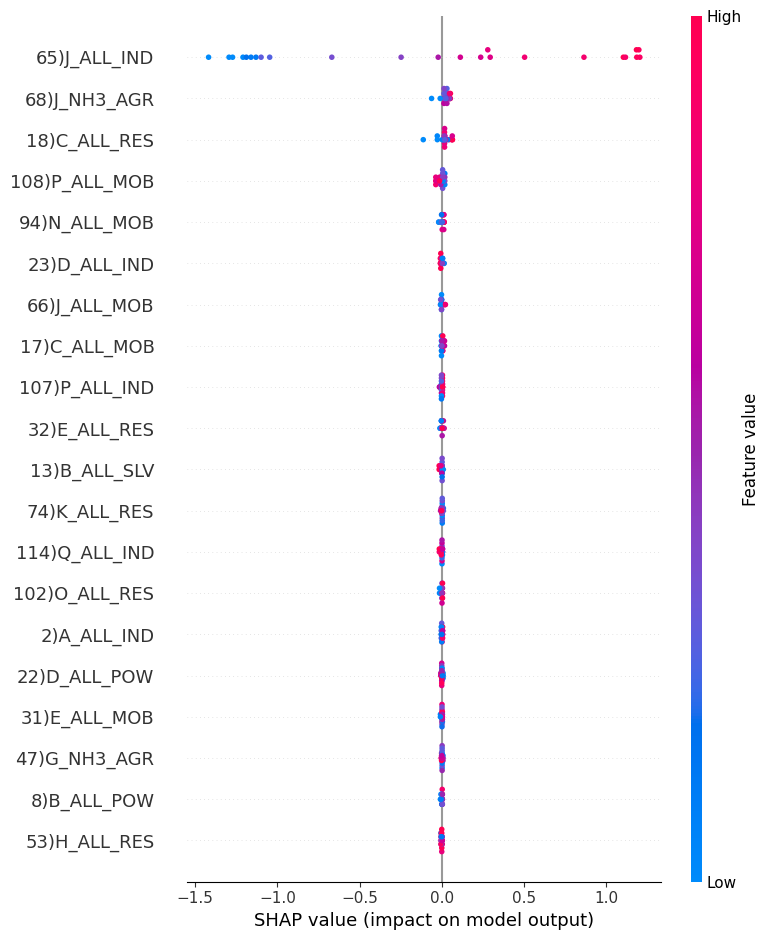

In [46]:
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns.tolist(),show=False,max_display=20)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


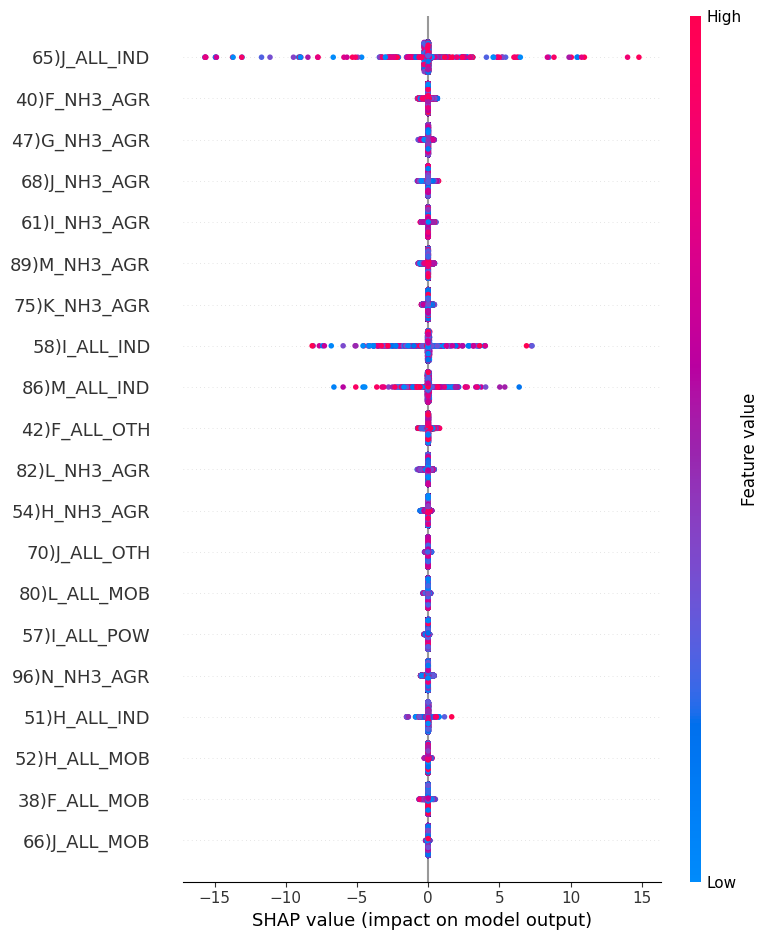

In [44]:
df_loop_list = []
for i in range(82*67):
    df_loop_list.append(X_test)

reshape_input = pd.concat(df_loop_list)
shap.summary_plot(shap_base.reshape(-1,119), reshape_input, feature_names=X_test.columns.tolist(),show=False,max_display=20)

In [ ]:
# sns.heatmap(shap_base[0,:,:,0][::-1])
for i, col_name in enumerate(X_test.columns.tolist()):
    plt.figure(figsize = [5,5])
    plt.title(col_name)
    sns.heatmap(shap_base[0,:,:,i][::-1])

* 지역단위

In [55]:
set(results_pd.ctp_kor_nm.tolist())

{'강원도',
 '경기도',
 '경상남도',
 '경상북도',
 '광주광역시',
 '대구광역시',
 '대전광역시',
 '부산광역시',
 '서울특별시',
 '세종특별자치시',
 '울산광역시',
 '인천광역시',
 '전라남도',
 '전라북도',
 '제주특별자치도',
 '충청남도',
 '충청북도'}

In [61]:
city_info_eng = {
    '강원도' : 'Gangwon',
 '경기도': 'Gyeonggi',
 '경상남도': 'Gyeong-Nam',
 '경상북도': 'Gyeong-Buk',
 '광주광역시': 'Gwangju',
 '대구광역시': 'Daegu',
 '대전광역시': 'Daejeon',
 '부산광역시': 'Busan',
 '서울특별시': 'Seoul',
 '세종특별자치시': 'Sejong',
 '울산광역시': 'Ulsan',
 '인천광역시': 'Incheon',
 '전라남도': 'Jeon-Nam',
 '전라북도': 'Jeon-Buk',
 '제주특별자치도': 'Jeju',
 '충청남도': 'Chung-Nam',
 '충청북도': 'Chung-Buk'
 }

# A	Seoul	서울
# B	Incheon	인천
# C	Busan	부산
# D	Daegu	대구
# E	Gwangju	광주
# F	Gyeonggi	경기
# G	Gangwon	강원
# H	Chung-Buk	충북
# I	Chung-Nam	충남
# J	Gyeong-Buk	경북
# K	Gyeong-Nam	경남
# L	Jeon-Buk	전북
# M	Jeon-Nam	전남
# N	Jeju	제주
# O	Daejeon	대전
# P	Ulsan	울산
# Q	Sejong	세종


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vm

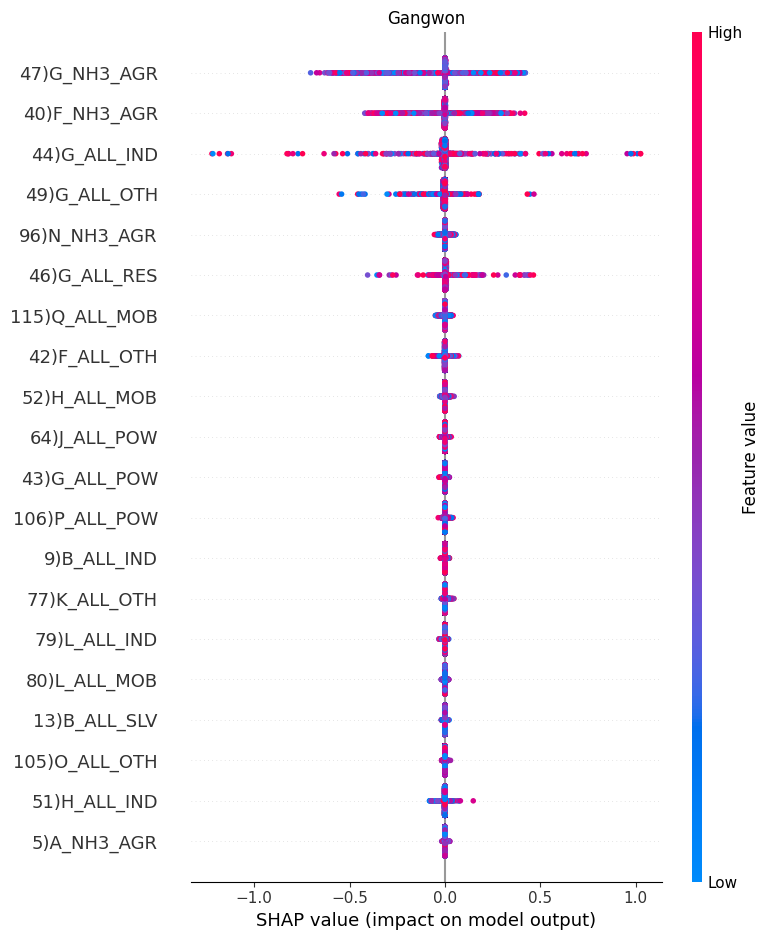

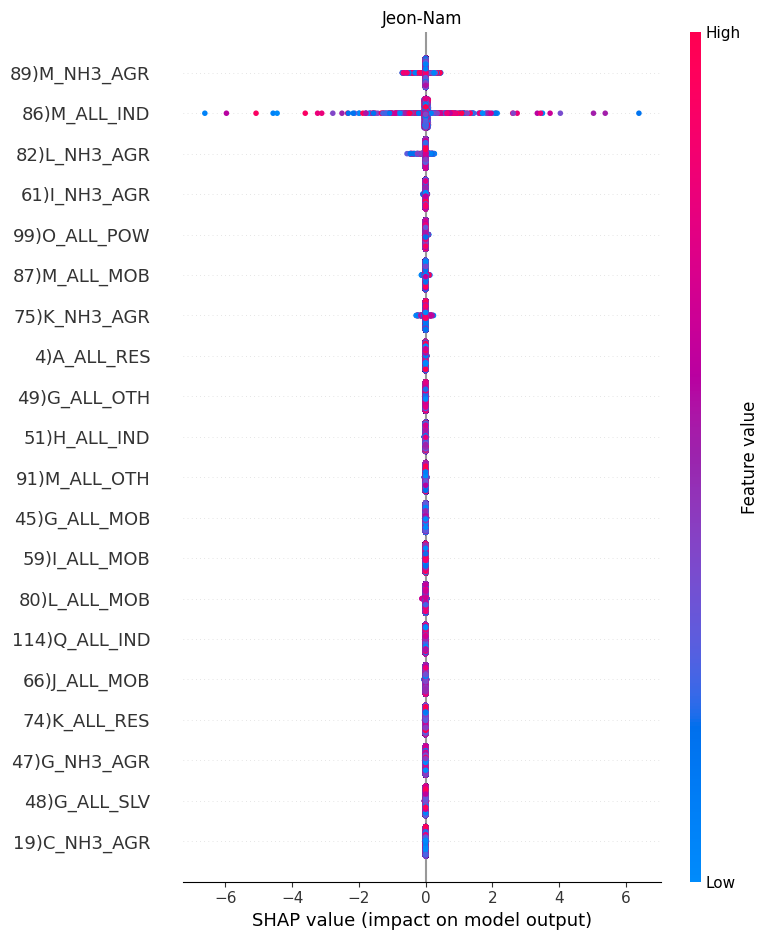

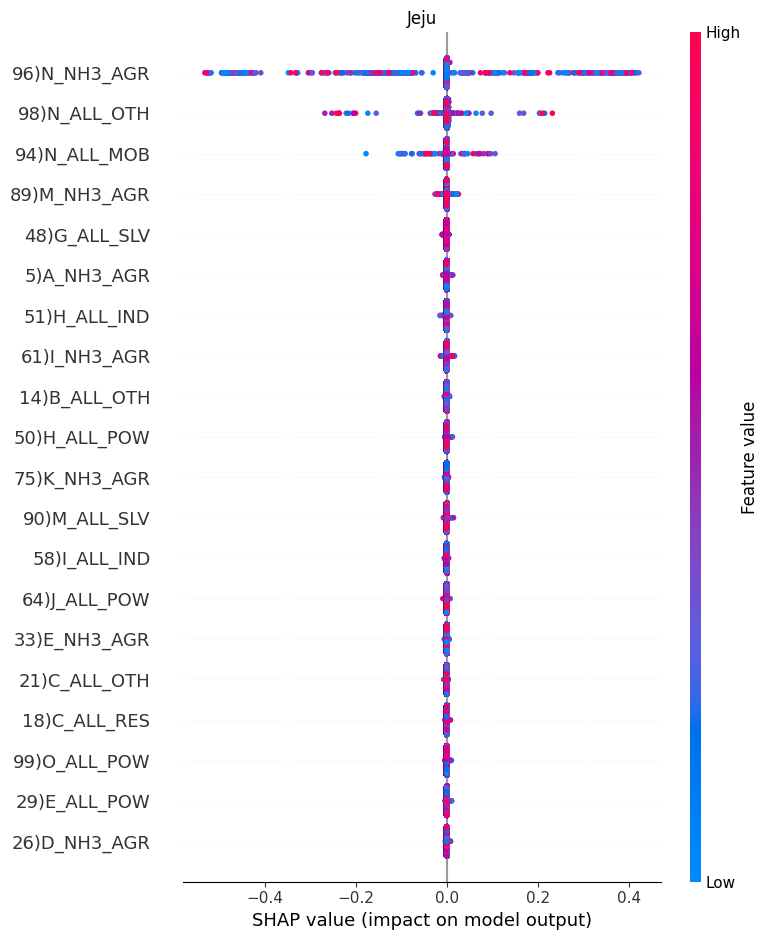

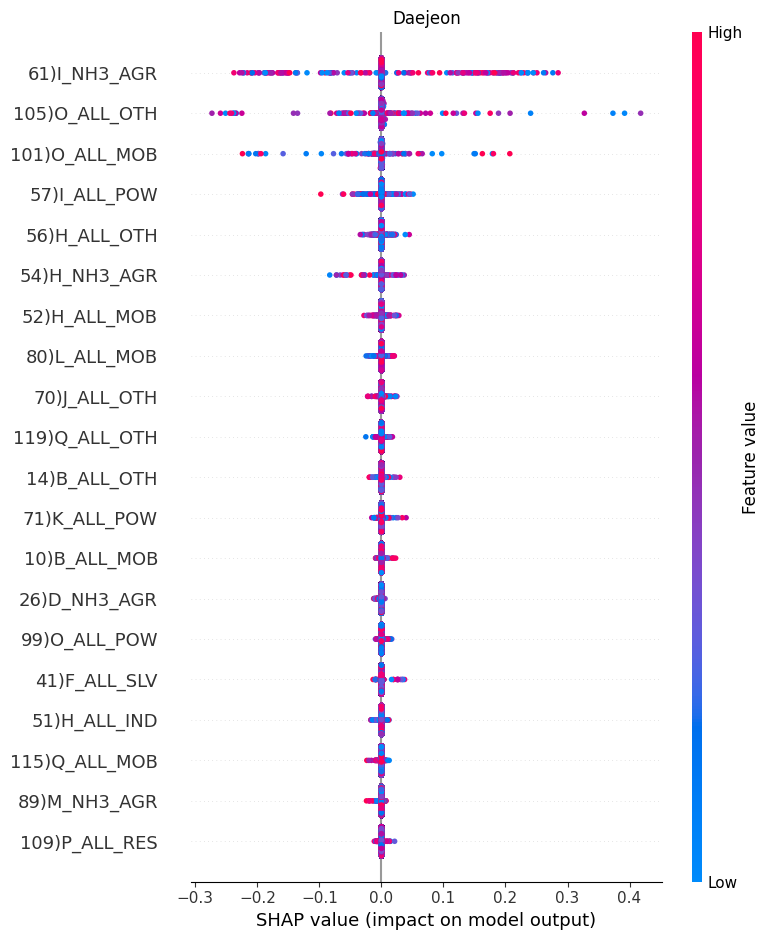

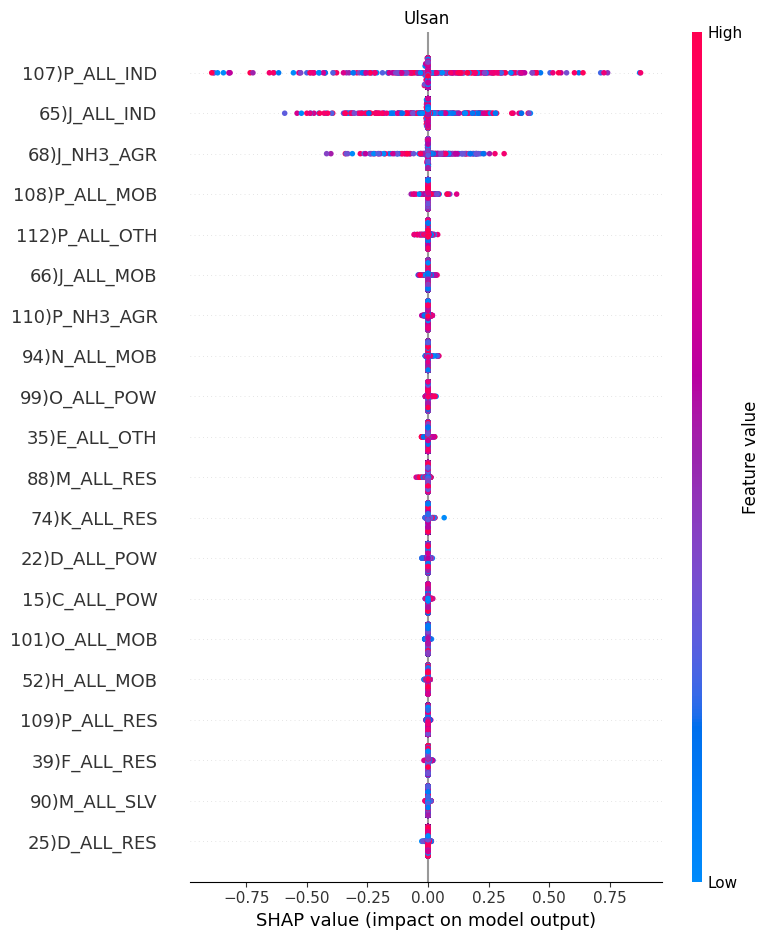

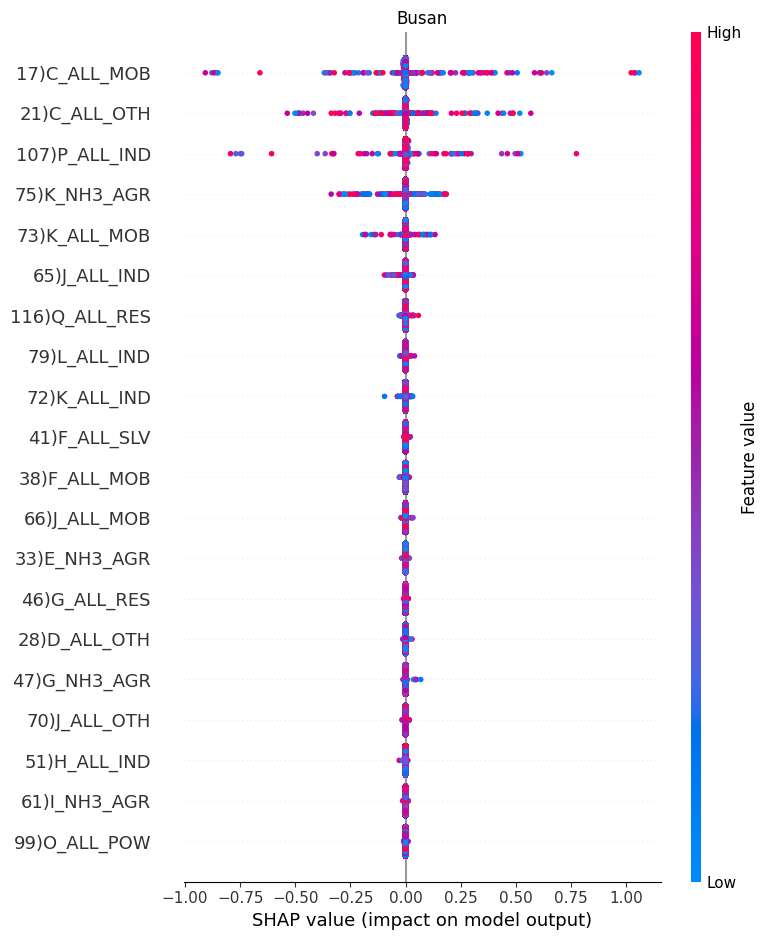

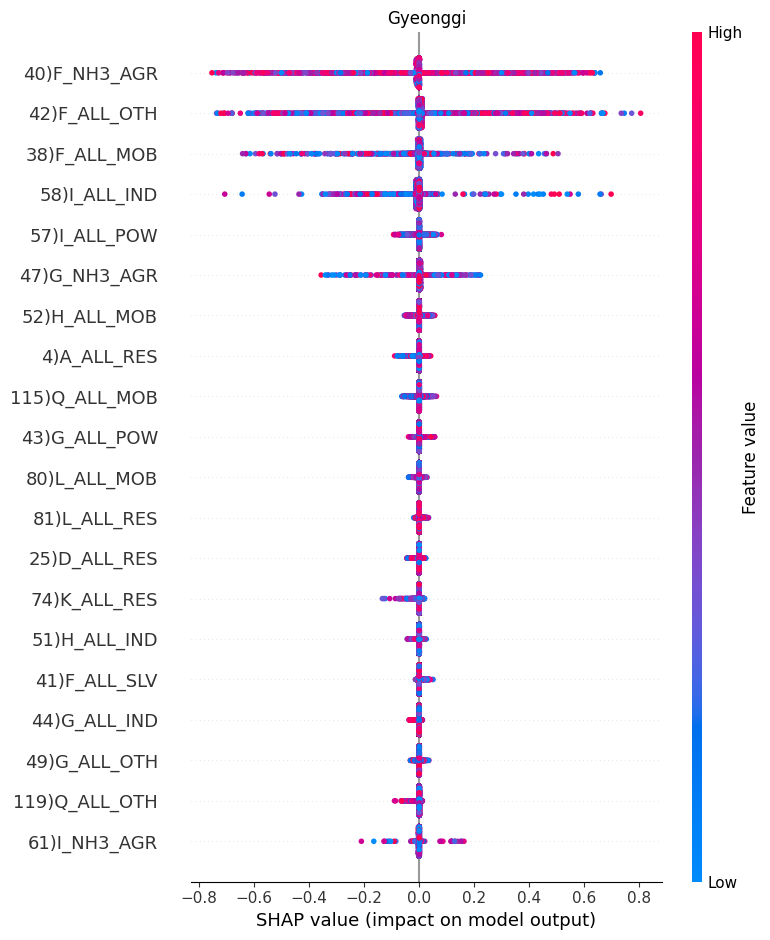

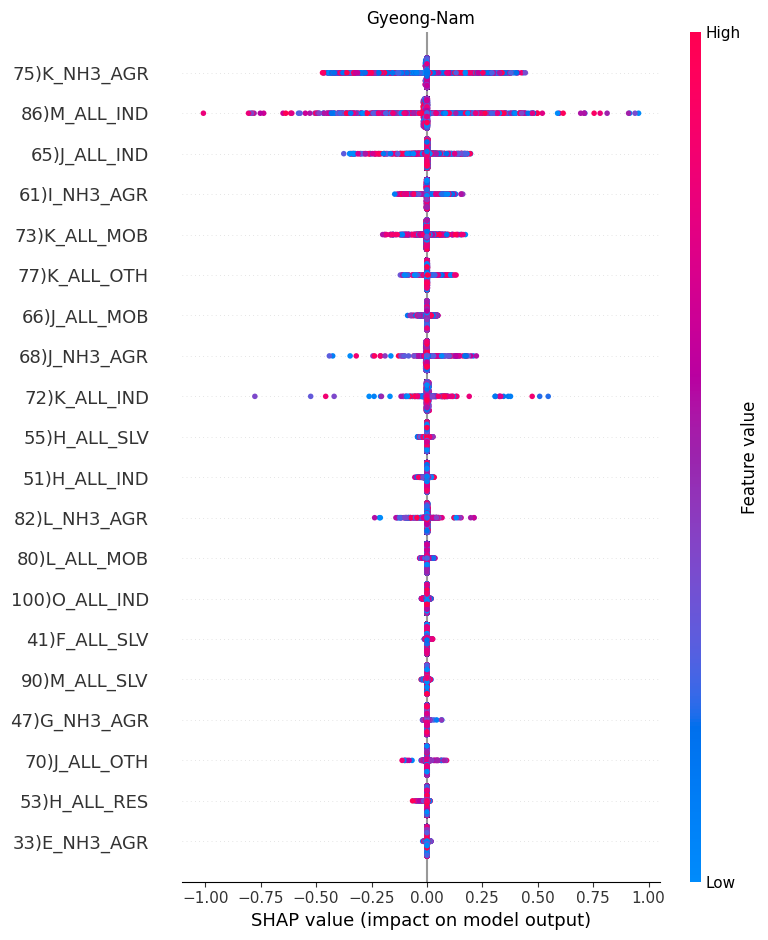

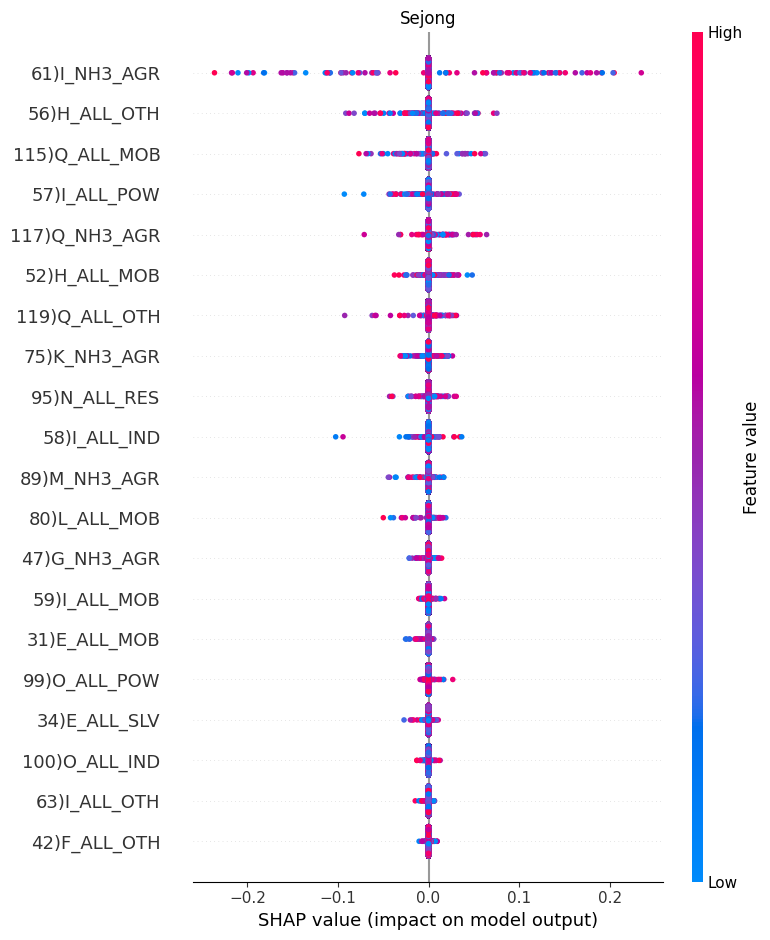

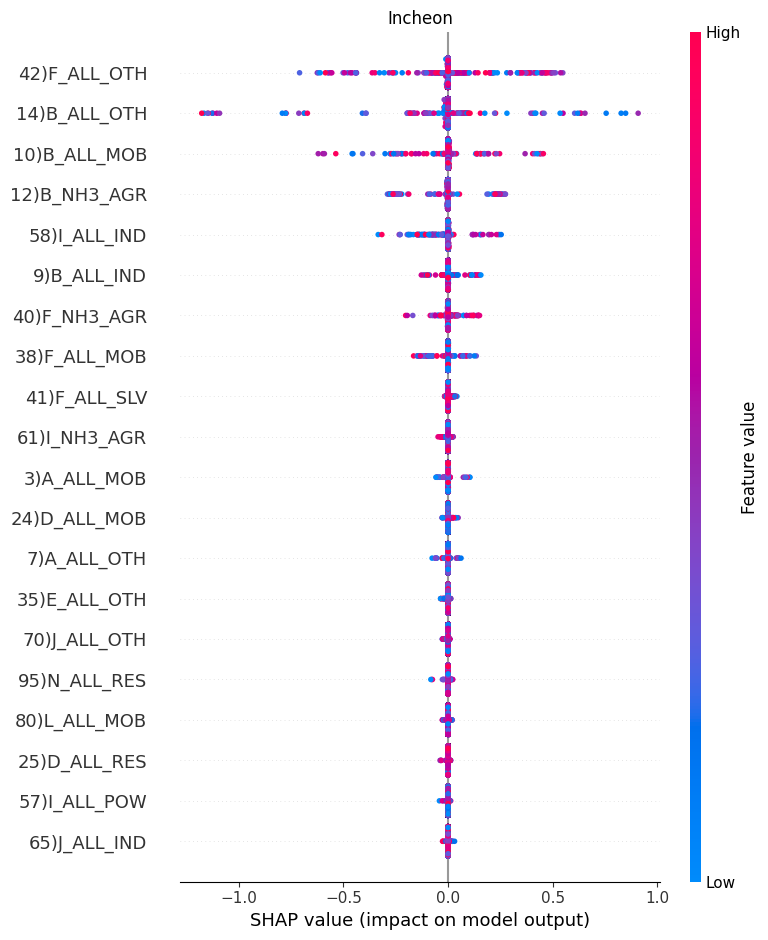

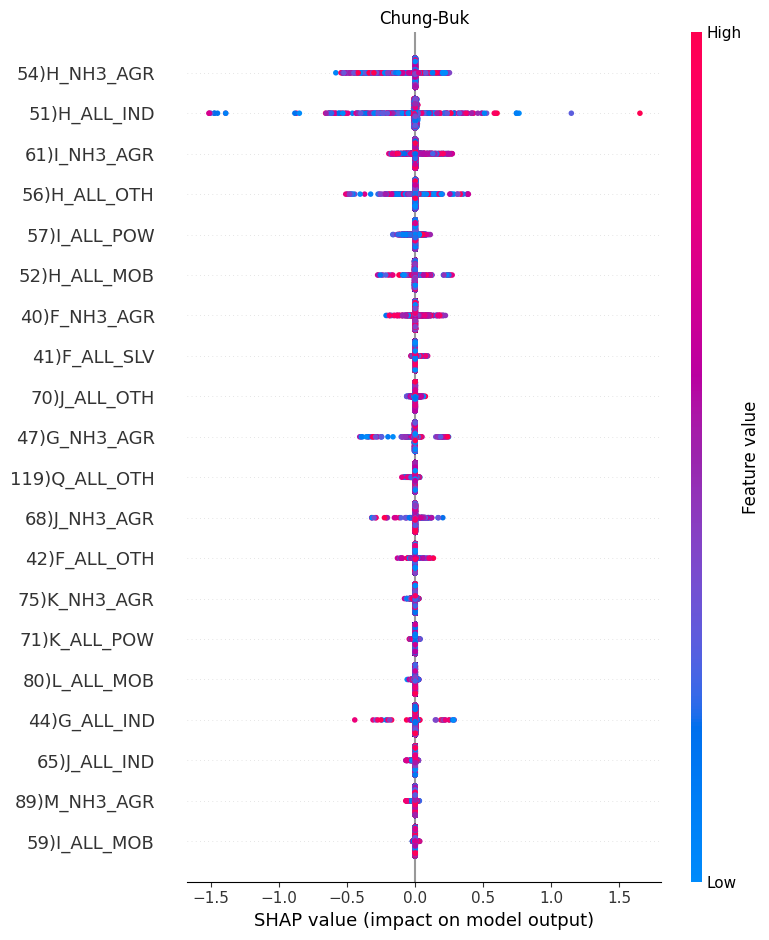

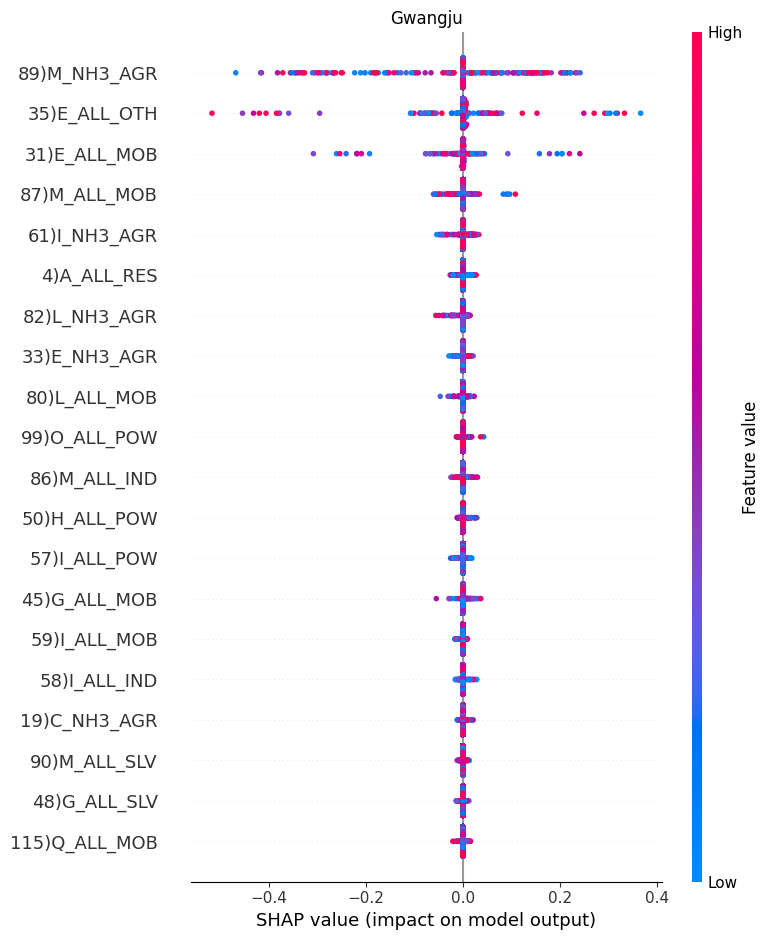

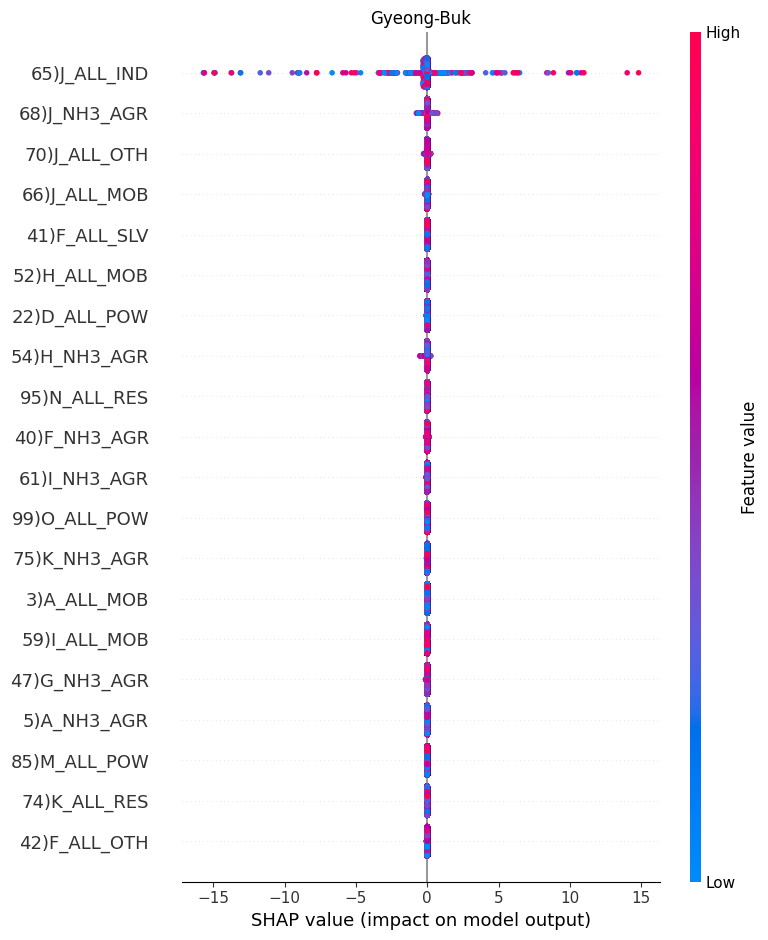

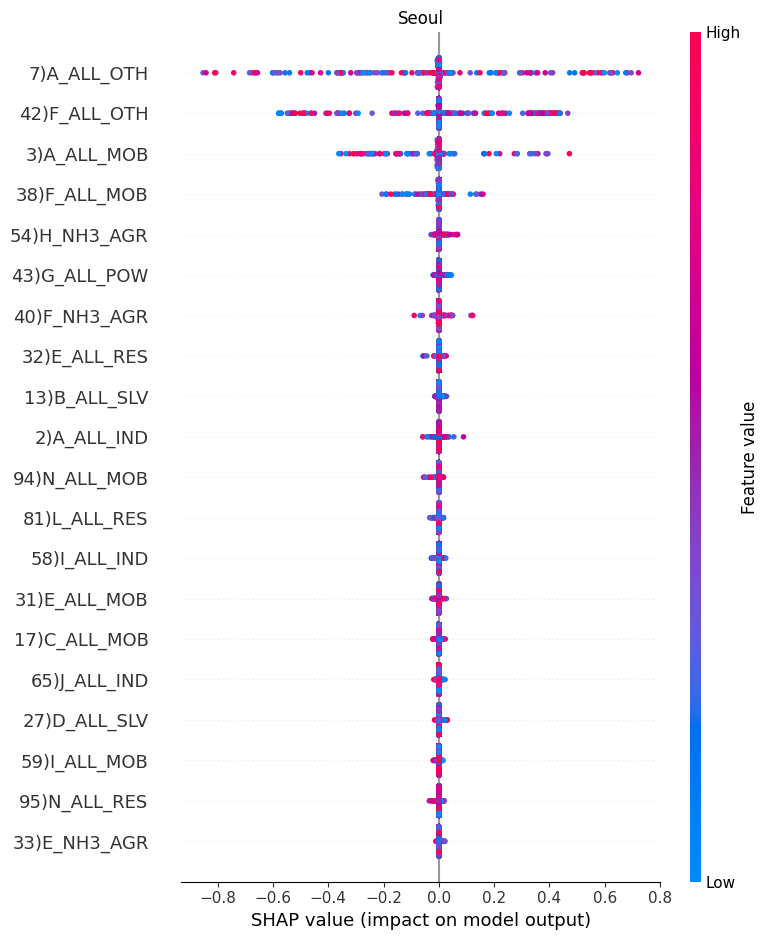

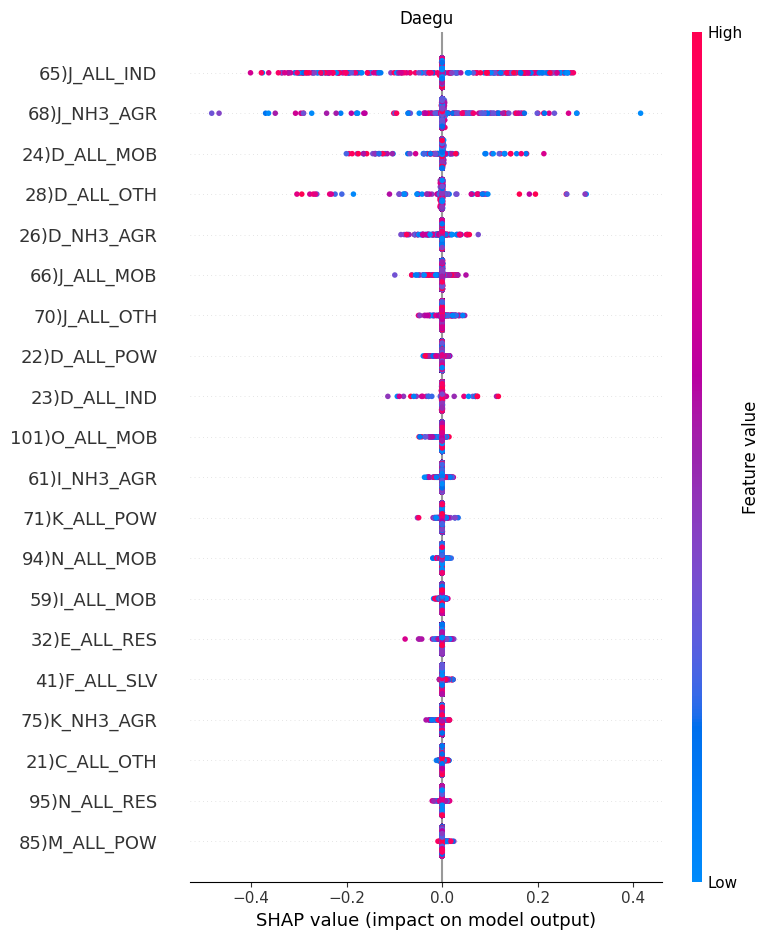

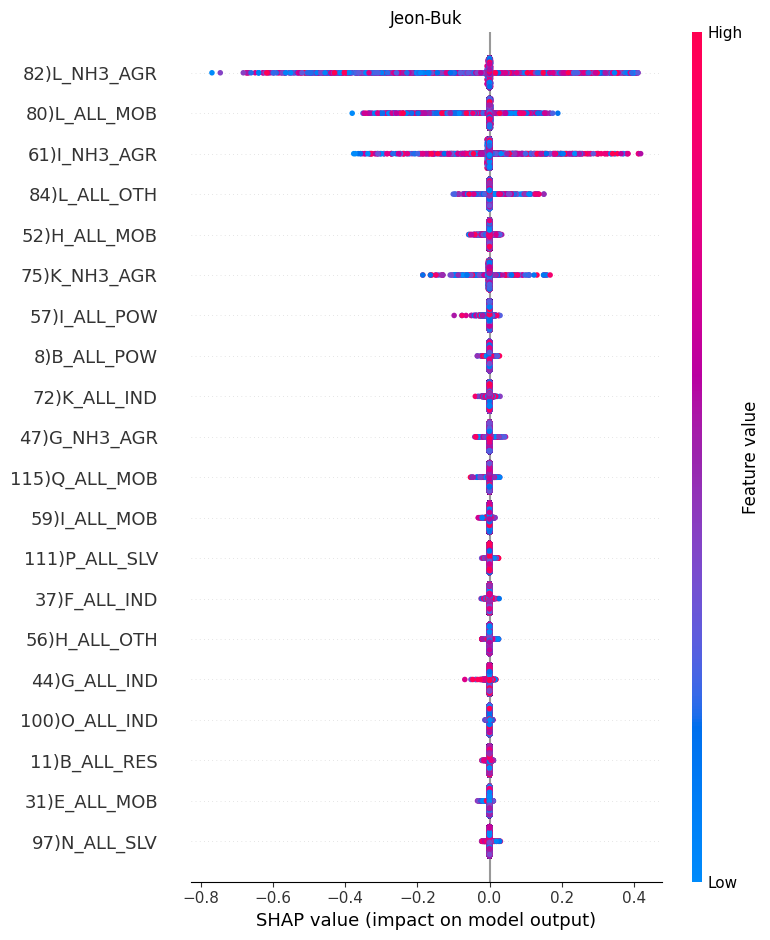

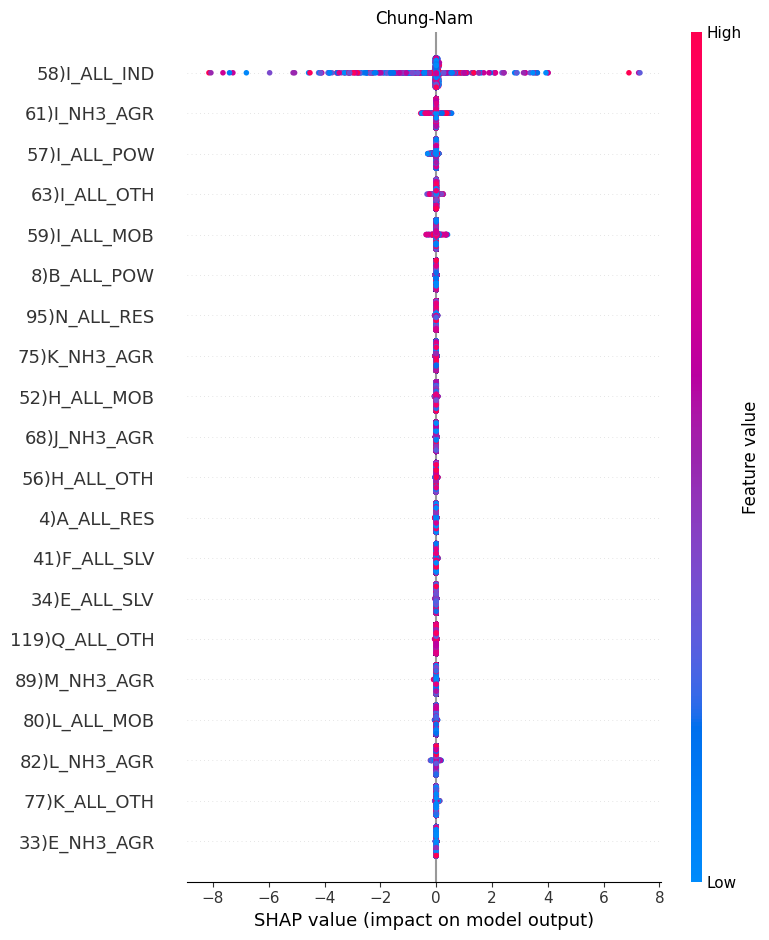

In [62]:
for i, city_name in enumerate(list(set(results_pd.ctp_kor_nm.tolist()))):
    plt.figure(figsize = [10,10])
    plt.title(city_info_eng[city_name])

    shap_base = np.zeros([y_test.shape[0],y_test.shape[1],y_test.shape[2],119])
    sub_results_pd = results_pd.loc[results_pd.ctp_kor_nm == city_name]
    for ind in sub_results_pd.index.tolist():
        ind_val = sub_results_pd.loc[ind,:].values
        # pred = ind_val[10].predict(X_test)
        shap_values = shap.TreeExplainer(ind_val[10]).shap_values(X_test)
        shap_base[:,ind_val[8],ind_val[9],:] = shap_values
    df_loop_list = []
    for i in range(82*67):
        df_loop_list.append(X_test)

    reshape_input = pd.concat(df_loop_list)
    shap.summary_plot(shap_base.reshape(-1,119), reshape_input, feature_names=X_test.columns.tolist(),show=False,max_display=20)
